# Airbnb Data Analysis - Asian Cities

In this project, I'm going to conduct data analysis on Airbnb data in Asian/Oceanian cities. The data is downloaded from [Inside Airbnb](http://insideairbnb.com/explore).
The main purpose of this project is to compare the Airbnb data in different cities and find problems/solutions for Airbnb hosts in Tokyo.

The cities I'm going to analyze are:
Tokyo: [http://insideairbnb.com/tokyo](http://insideairbnb.com/tokyo). Data collected on 2023-09-24.
Sydney: [http://insideairbnb.com/sydney](http://insideairbnb.com/sydney). Data collected on 2023-09-04.
Melbourne: [http://insideairbnb.com/melbourne](http://insideairbnb.com/melbourne). Data collected on 2023-09-04.
Singapore: [http://insideairbnb.com/singapore](http://insideairbnb.com/singapore). Data collected on 2023-09-04.
Hong Kong: [http://insideairbnb.com/hong-kong](http://insideairbnb.com/hong-kong). Data collected on 2023-09-17.
Taipei: [http://insideairbnb.com/taipei](http://insideairbnb.com/taipei). Data collected on 2023-09-25.
Bangkok: [http://insideairbnb.com/bangkok](http://insideairbnb.com/bangkok). Data collected on 2023-09-22.

# Task 1: Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
city_names = ["tokyo", "sydney", "melbourne", "singapore", "hongkong", "taipei", "bangkok"]

In [44]:
cities_df = dict()
for city in city_names:
    cities_df[city] = pd.read_csv("./data/listings_{c}.csv".format(c=city))

In [24]:
cities_df["tokyo"].dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 75, dtype: object

## Data Cleaning
TODO: Better data cleansing

In [25]:
# # Columns with more than 50% missing values
# columns_with_missing_values = set()
#
# for city in city_names:
#     for col in cities_df[city].columns:
#         if cities_df[city][col].isnull().sum() / len(cities_df[city]) > 0.5:
#             columns_with_missing_values.add(col)
#
# columns_copy = columns_with_missing_values.copy()
# for column in columns_copy:
#     if column.startswith("review"):
#         columns_with_missing_values.discard(column)
#     if column.startswith("bed"):
#         columns_with_missing_values.discard(column)
#
# print("Columns that at least one city has more than 50% missing values:")
# print(columns_with_missing_values)
#
# # Remove them
# for city in city_names:
#     cities_df[city].drop(columns=columns_with_missing_values, inplace=True)

In [26]:
# Convert price to numeric which is currently like "$1,000"
for city in city_names:
    cities_df[city]['price'] = cities_df[city]['price'].str.replace('$', '').str.replace(',', '').astype(float)

assert cities_df[city_names[0]]['price'].dtype == 'float64'


/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_18471/975640382.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cities_df[city]['price'] = cities_df[city]['price'].str.replace('$', '').str.replace(',', '').astype(float)


In [27]:
numeric_columns = cities_df[city_names[0]].select_dtypes(include=['int64', 'float64']).columns
numeric_columns = numeric_columns.drop(["id", "host_id", "latitude", "longitude", "scrape_id"])

def plot_aggregated_missing_values():
    combined_data = []

    for city, df in cities_df.items():
        df_subset = df[numeric_columns].copy()
        df_subset['city'] = city
        combined_data.append(df_subset)

    import math

    # Concatenate all the data into a single DataFrame
    all_cities_df = pd.concat(combined_data)

    num_plots = len(numeric_columns)
    num_cols = int(math.sqrt(num_plots)) + 1
    num_rows = num_plots // num_cols + (num_plots % num_cols > 0)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    if num_rows == 1:
        axs = axs.reshape(1, -1)

    for i, col_name in enumerate(numeric_columns):
        row = i // num_cols
        col_index = i % num_cols

        ax = axs[row, col_index]

        # Plotting the combined data with a hue for the city
        sns.boxplot(x='city', y=col_name, data=all_cities_df, ax=ax)
        ax.set_title(col_name)
        ax.tick_params(axis='x', rotation=45)  # Rotate city names for readability

    # Remove any unused subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()

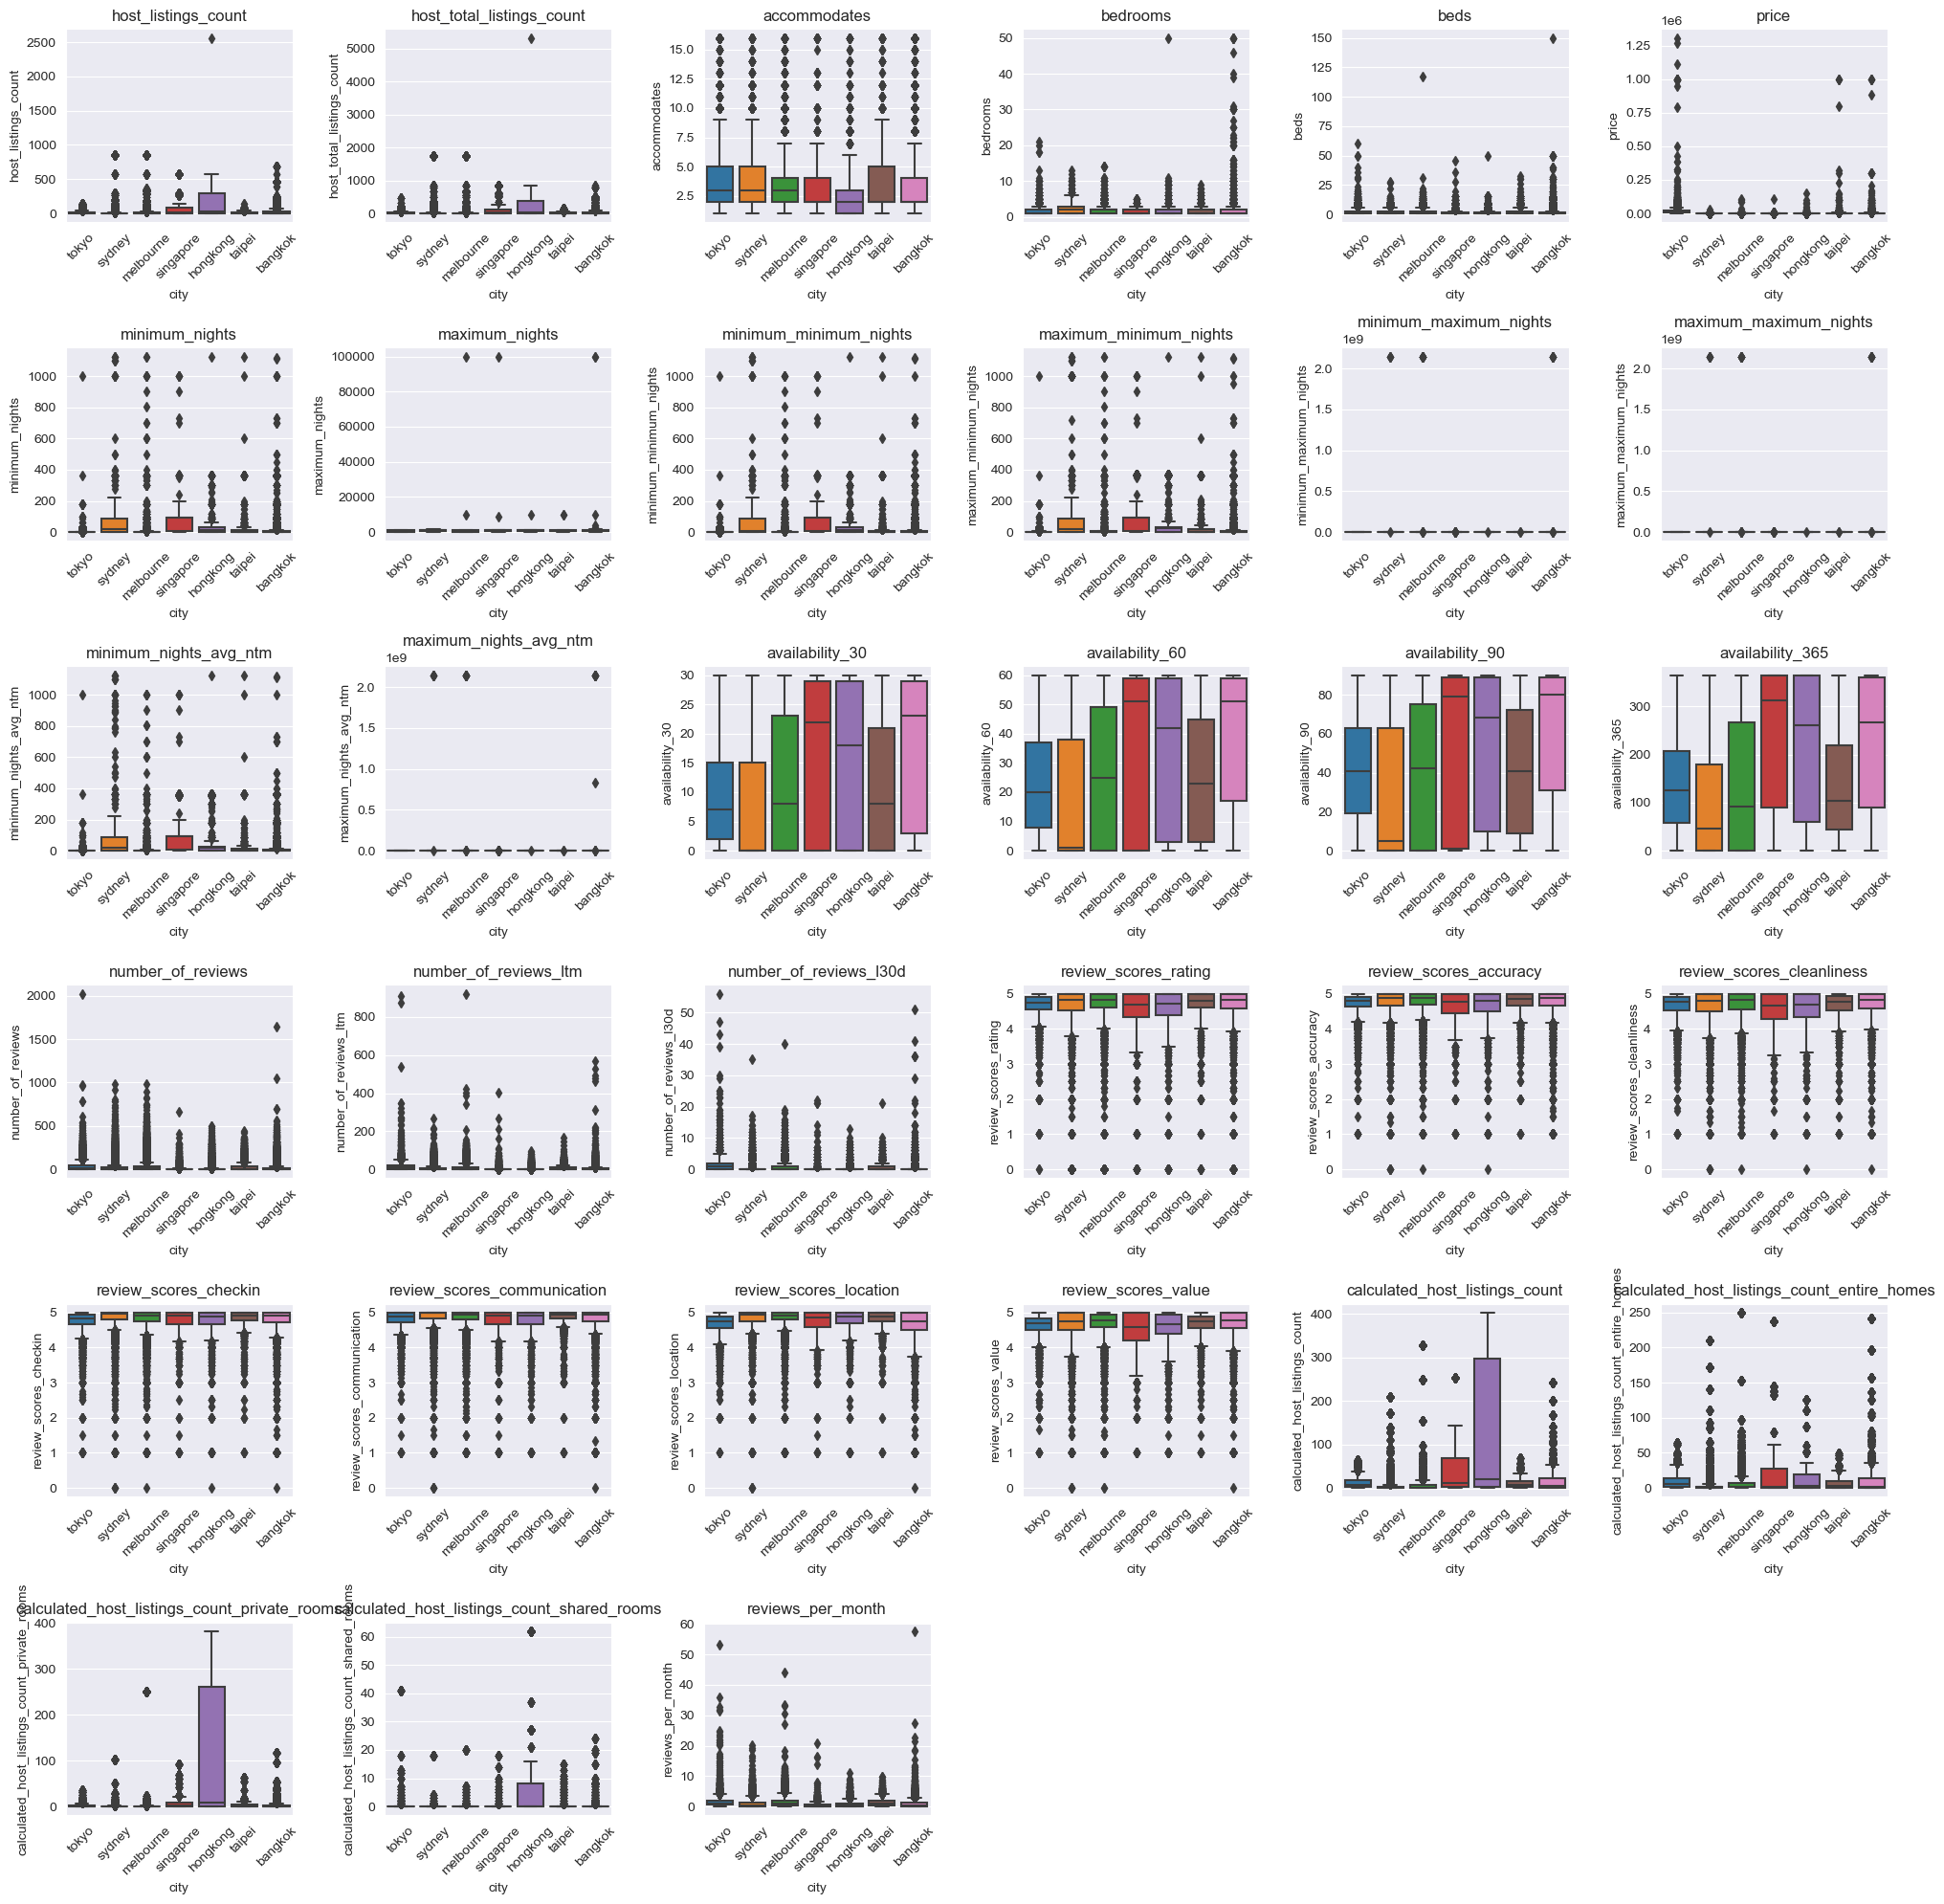

In [9]:
plot_aggregated_missing_values()

## Exploratory Data Analysis

### 1. How does the Airbnb market in Tokyo compare to other Asian/Oceanian cities?

#### 1.1. Number of listings in each city
Tokyo has the fourth most number of listings among the seven cities, following Sydney, Melbourne, and Bangkok.


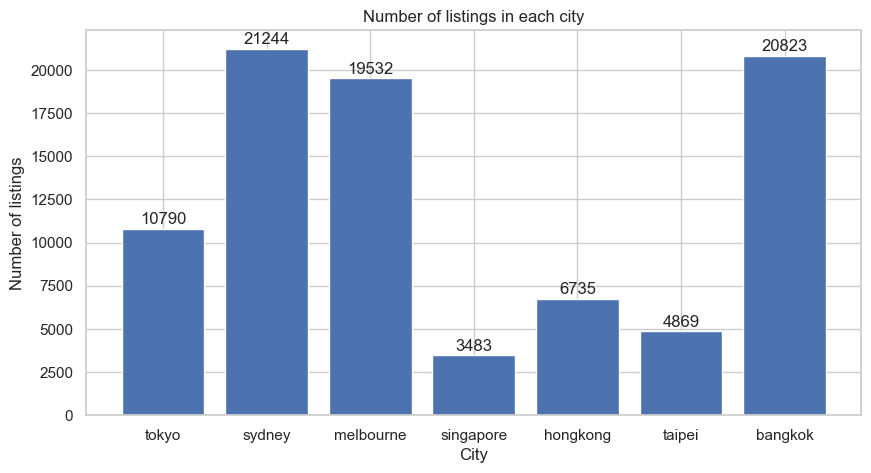

In [31]:
# Plot the number of listings in each city
num_listings = []

for city in city_names:
    num_listings.append(len(cities_df[city]))

plt.figure(figsize=(10, 5))
plt.bar(city_names, num_listings)
plt.xlabel("City")
plt.ylabel("Number of listings")
plt.title("Number of listings in each city")

for i, num_listing in enumerate(num_listings):
    plt.text(i, num_listing + 100, str(num_listing), ha='center', va='bottom')

plt.show()

#### The location of listings in each city

In [32]:
import folium

def generate_city_map(city_df, city_name):
    central_lat = city_df['latitude'].mean()
    central_lon = city_df['longitude'].mean()

    # Create a map centered around the central point of the city
    city_map = folium.Map(location=[central_lat, central_lon], zoom_start=12)

    # Add points for each listing in the city
    for idx, row in city_df.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(city_map)

    # display the map in browser
    city_map.save('./map/listings_map_{c}.html'.format(c=city_name))

# Assuming 'cities_df' is your dictionary containing DataFrames for each city
for city_name, city_df in cities_df.items():
    generate_city_map(city_df, city_name)


In [49]:
# Put the prices in different currencies altogether in USD.

exchange_rates = {
    "tokyo": {"2023-09-24": 0.0067},
    "sydney": {"2023-09-05":  0.6459, "2023-09-04": 0.6459},
    "melbourne": {"2023-09-05": 0.6381, "2023-09-04": 0.6459},
    "singapore": {"2023-09-04": 0.7382, "2023-09-23": 0.7323},
    "hongkong": {"2023-09-17": 0.1276},
    "taipei": {"2023-09-26": 0.02741, "2023-09-25": 0.0311},
    "bangkok": {"2023-09-22": 0.0283},
}

def convert_to_usd(city, local_price, date):
    if date not in exchange_rates[city]:
        print("Warning: the exchange rate for {d} does not exist in {city}".format(d=date, city=city))

    rate = exchange_rates[city][date]
    usd_price = local_price * rate

    return usd_price

for city, city_df in cities_df.items():
    try:
        # Convert string to float
        city_df['price'] = city_df['price'].str.replace(',', '').str.replace('$', '').astype(float)
    except AttributeError:
        continue

    converted_prices = []

    for index, row in city_df.iterrows():
        converted_prices.append(convert_to_usd(city, row['price'], row['last_scraped']))

    city_df['price'] = converted_prices

#### 1.2. Price distribution in each city

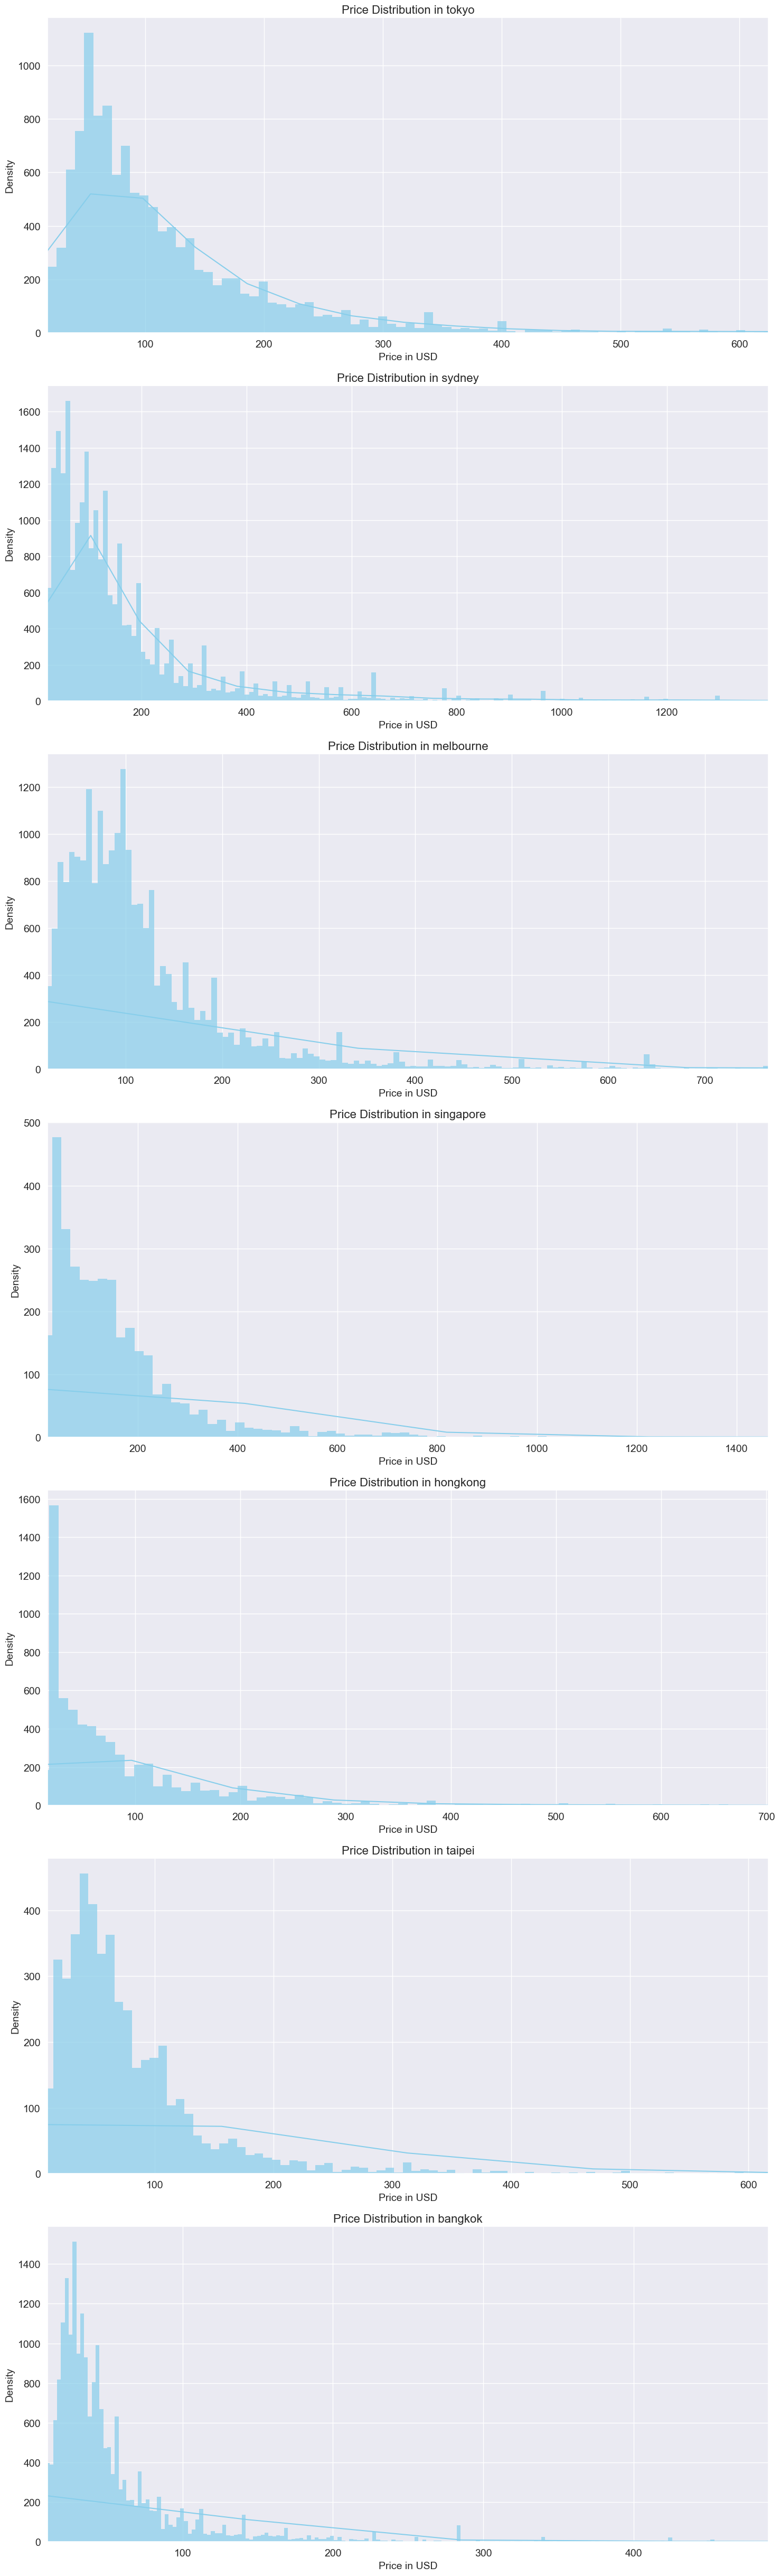

In [60]:
import numpy as np

# Plot the distribution of prices in each city
num_cities = len(cities_df)
fig, axs = plt.subplots(num_cities, 1, figsize=(15, 7 * num_cities))  # making the plot taller for each city

plt.rcParams['font.size'] = 14

for i, (city, city_df) in enumerate(cities_df.items()):
    sns.histplot(city_df['price'], kde=True, ax=axs[i], color='skyblue', alpha=0.7, linewidth=0)

    axs[i].set_title(f'Price Distribution in {city}', fontsize=16)
    axs[i].set_xlabel('Price in USD', fontsize=14)
    axs[i].set_ylabel('Density', fontsize=14)

    lower_bound = city_df['price'].quantile(0.01)  # 1st percentile
    upper_bound = city_df['price'].quantile(0.99)  # 99th percentile
    axs[i].set_xlim(lower_bound, upper_bound)

    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

Tokyo has the third-highest median price among the seven cities, following Sydney and Melbourne.

It is notable that Sydney has listings with very high prices which are not seen in other cities. This suggests some listings in Sydney have factors that can raise a listing's price significantly, such as a large number of bedrooms or a great location.

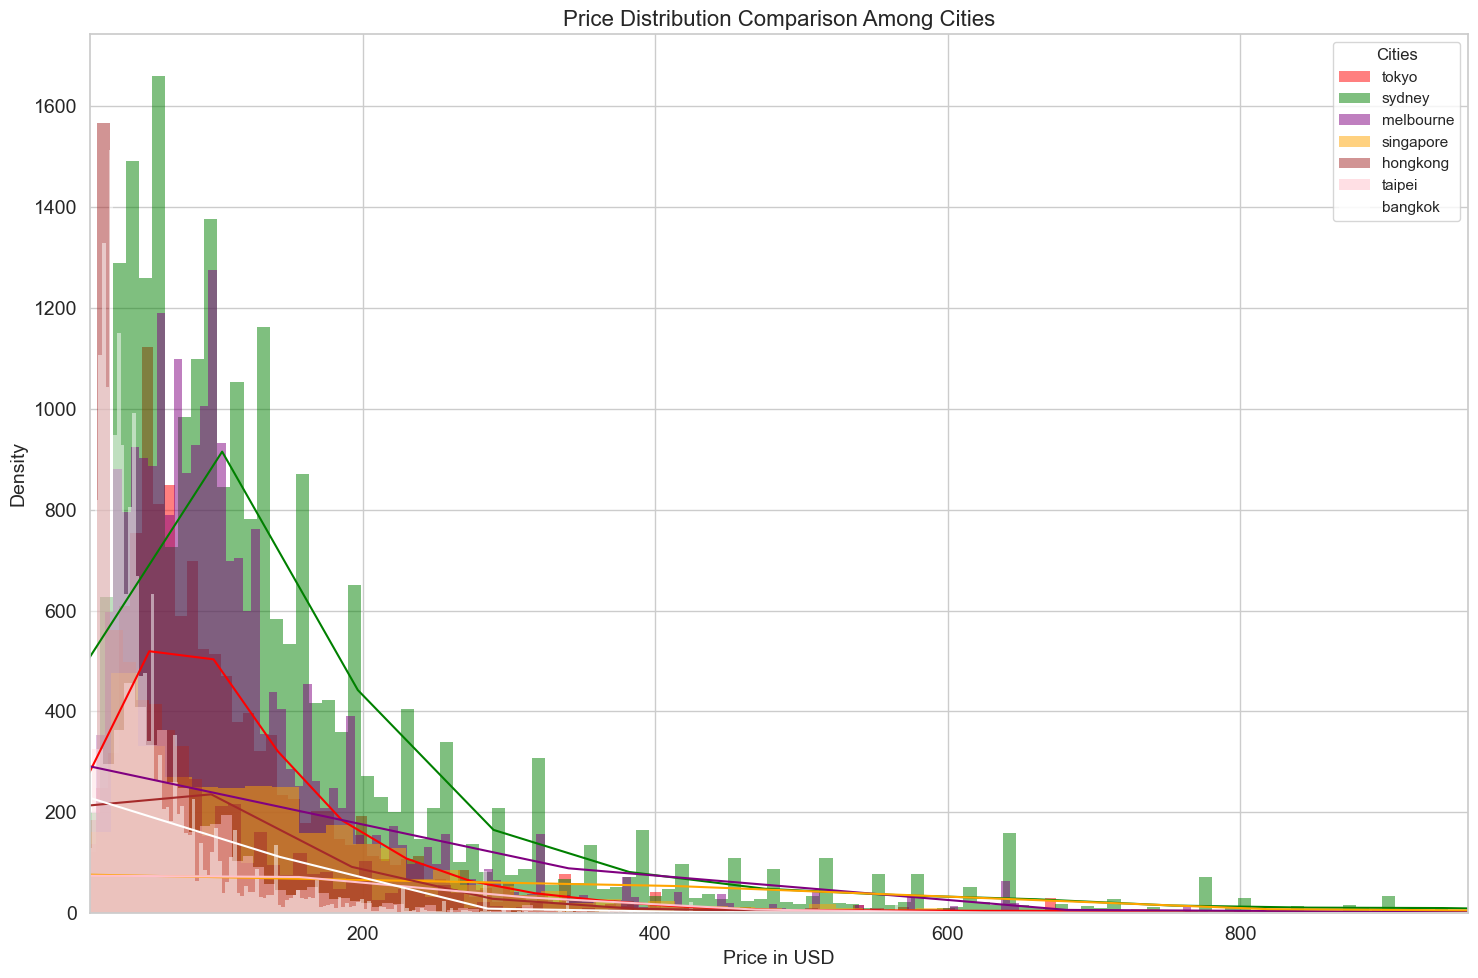

In [63]:
# Plot the distribution of each city in the same plot for comparison
fig, ax = plt.subplots(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 14

colors = ['red', 'green', 'purple', 'orange', 'brown', 'pink', 'white']

all_prices = [price for city_df in cities_df.values() for price in city_df['price']]
global_lower_bound = np.percentile(all_prices, 1)
global_upper_bound = np.percentile(all_prices, 99)

for i, (city, city_df) in enumerate(cities_df.items()):
    sns.histplot(city_df['price'], ax=ax, color=colors[i % len(colors)],
                 alpha=0.5, linewidth=0, label=city, kde=True)  # Label for the legend

ax.set_title('Price Distribution Comparison Among Cities', fontsize=16)
ax.set_xlabel('Price in USD', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim(global_lower_bound, global_upper_bound)

ax.legend(title='Cities')

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

The median of the price distribution in Tokyo is higher than that in other cities, except for Sydney, Melbourne, and Singapore.

Taipei and Melbourne have listings that are extremely low prices.

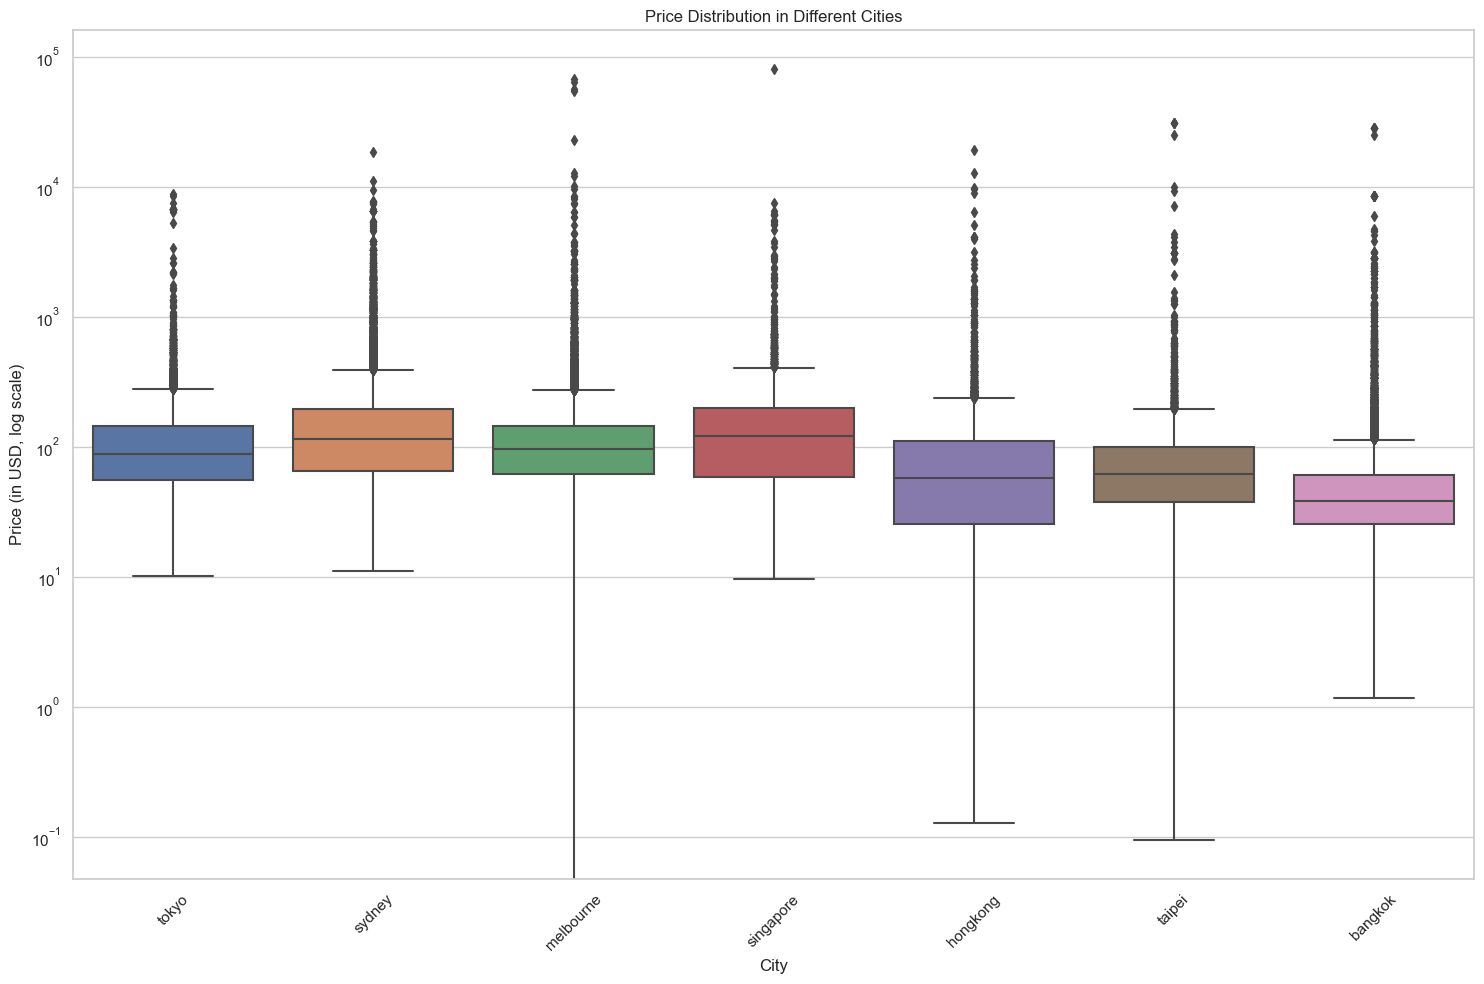

In [64]:
# Plot the quantile boxplot to show price distribution of each city
all_cities_data = pd.DataFrame()

for city, city_df in cities_df.items():
    temp_df = city_df.copy()
    temp_df['City'] = city
    all_cities_data = pd.concat([all_cities_data, temp_df], ignore_index=True)

plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

ax = sns.boxplot(x='City', y='price', data=all_cities_data)

ax.set_yscale('log')  # Use logarithmic scale due to wide range of prices
ax.set_title('Price Distribution in Different Cities')
ax.set_xlabel('City')
ax.set_ylabel('Price (in USD, log scale)')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


It looks like Melbourne has a listing where the price is 0 USD.

In [65]:
# Display the 5 lowest price listings in each city
for city, city_df in cities_df.items():
    print(f"5 lowest price listings in {city}:")
    data = city_df[['name', 'price', 'bedrooms', 'beds']].sort_values(by='price').head(5)
    print(data)
    print()

5 lowest price listings in tokyo:
                                                  name  price  bedrooms  beds
793  Rental unit in Toshima-ku · 1 bedroom · 1 bed ...  10.05       NaN   1.0
329  Rental unit in Toshima-ku · ★4.77 · 1 bedroom ...  10.05       NaN   1.0
331  Rental unit in Toshima-ku · ★4.33 · 1 bedroom ...  10.05       NaN   1.0
684  Rental unit in Toshima · ★4.50 · 1 bedroom · 4...  10.05       NaN   4.0
492  Rental unit in Toshima-ku · ★4.56 · 1 bedroom ...  10.05       NaN   1.0

5 lowest price listings in sydney:
                                                    name    price  bedrooms  \
11715  Loft in Botany · ★4.33 · 6 bedrooms · 4 beds ·...  10.9803       6.0   
13009  Rental unit in Chippendale · 1 bedroom · 1 bed...  11.6262       NaN   
12235  Home in Darlinghurst · 1 bedroom · 1 bed · 1 s...  11.6262       NaN   
10131  Home in Quakers Hill · ★4.68 · 1 bedroom · 1 b...  11.6262       NaN   
8678   Home in Bankstown · 1 bedroom · 1 bed · 1.5 sh...  11.6262  

#### 1.3 Hosts with the most listings in each city
In Tokyo, there are 2 hosts that have more than 60 listing, while in other cities except for Taipei, there are at least more than 3 hosts that have more than 60 listings.
Let's take a look at the hosts with the most listings in each city in next section.

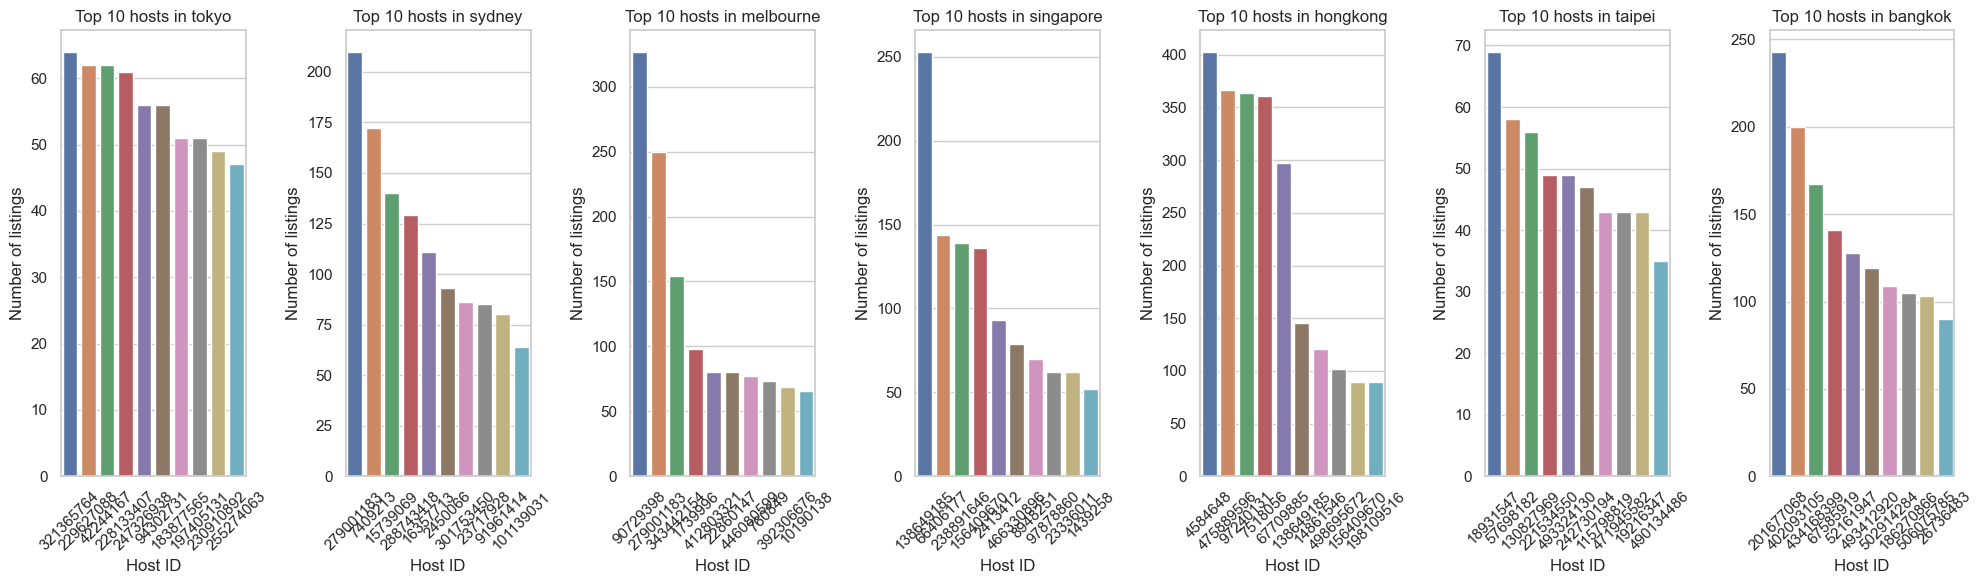

In [66]:
# Plot the hosts with the most listings in each city by using the "host_id" column in each city's DataFrame
fig, axs = plt.subplots(1, len(city_names), figsize=(20, 6))

for i, city in enumerate(city_names):
    city_df = cities_df[city]

    # Create a new DataFrame with the number of listings for each host
    host_listings_df = city_df.groupby('host_id').size().reset_index(name='num_listings')

    # Sort the hosts by the number of listings
    host_listings_df.sort_values(by='num_listings', ascending=False, inplace=True)

    # Take the top 10 hosts with the most listings
    top_hosts = host_listings_df.head(10)

    # Reset the index so that the plot follows the new order
    top_hosts.reset_index(drop=True, inplace=True)

    # Plot the top 10 hosts sorted by the number of listings
    sns.barplot(x='host_id', y='num_listings', data=host_listings_df.head(10), ax=axs[i], order=top_hosts['host_id'])
    axs[i].set_title(f'Top 10 hosts in {city}')
    axs[i].set_xlabel('Host ID')
    axs[i].set_ylabel('Number of listings')

    # Rotate x-axis labels for readability
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Top hosts in tokyo:


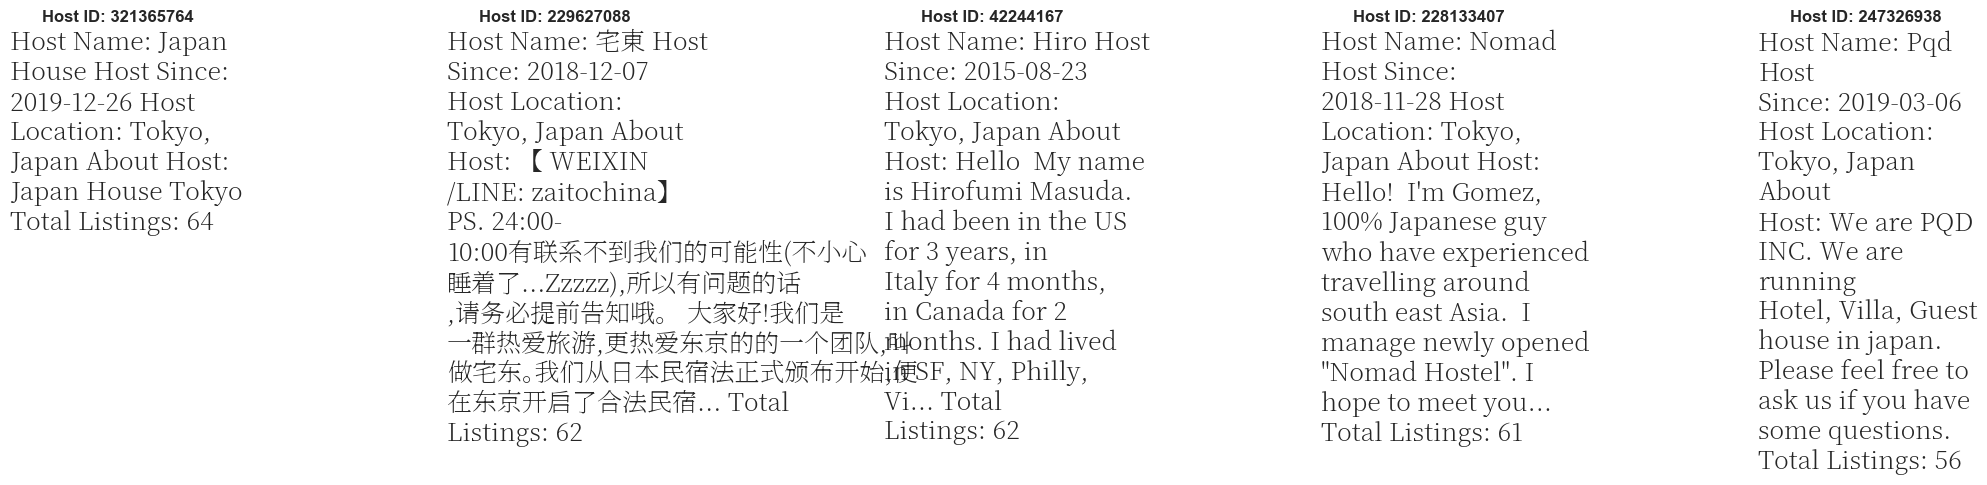

Top hosts in sydney:


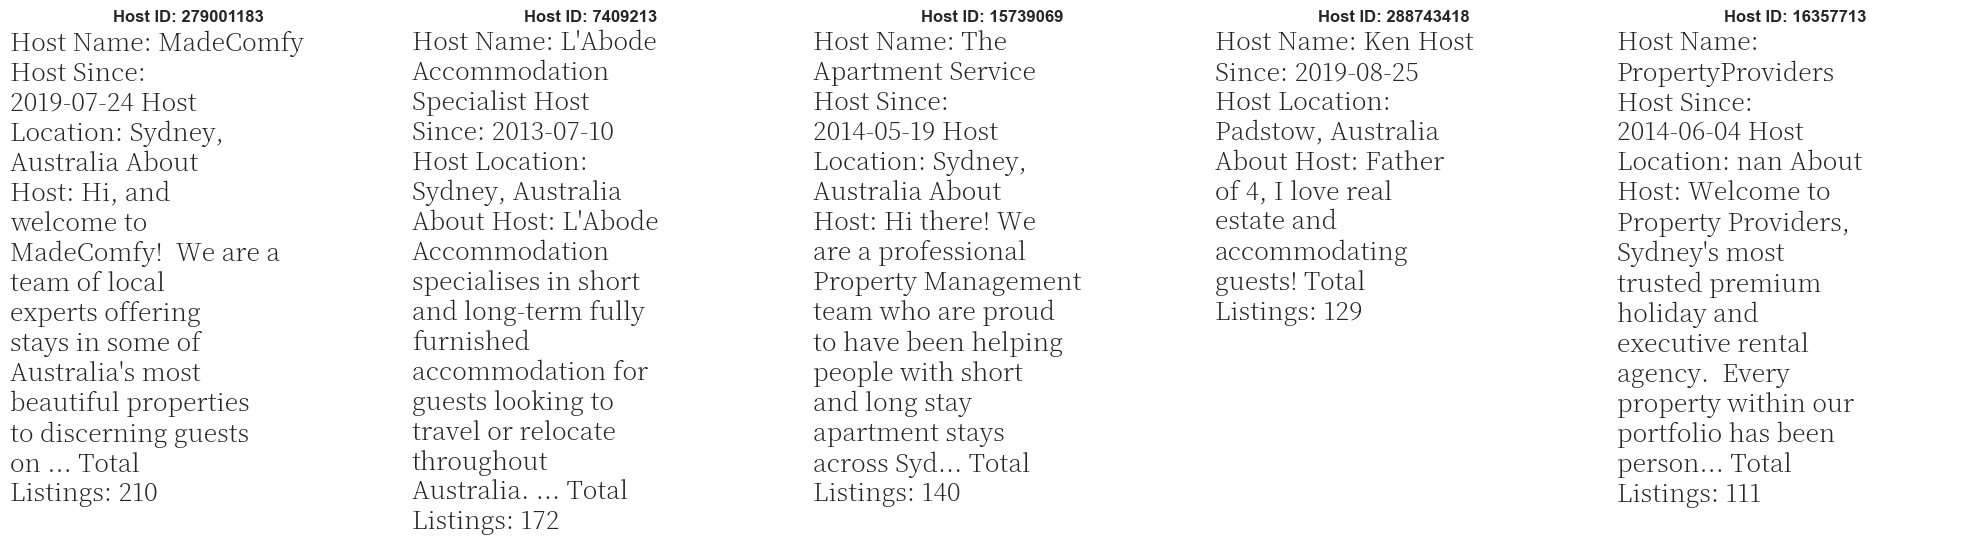

Top hosts in melbourne:


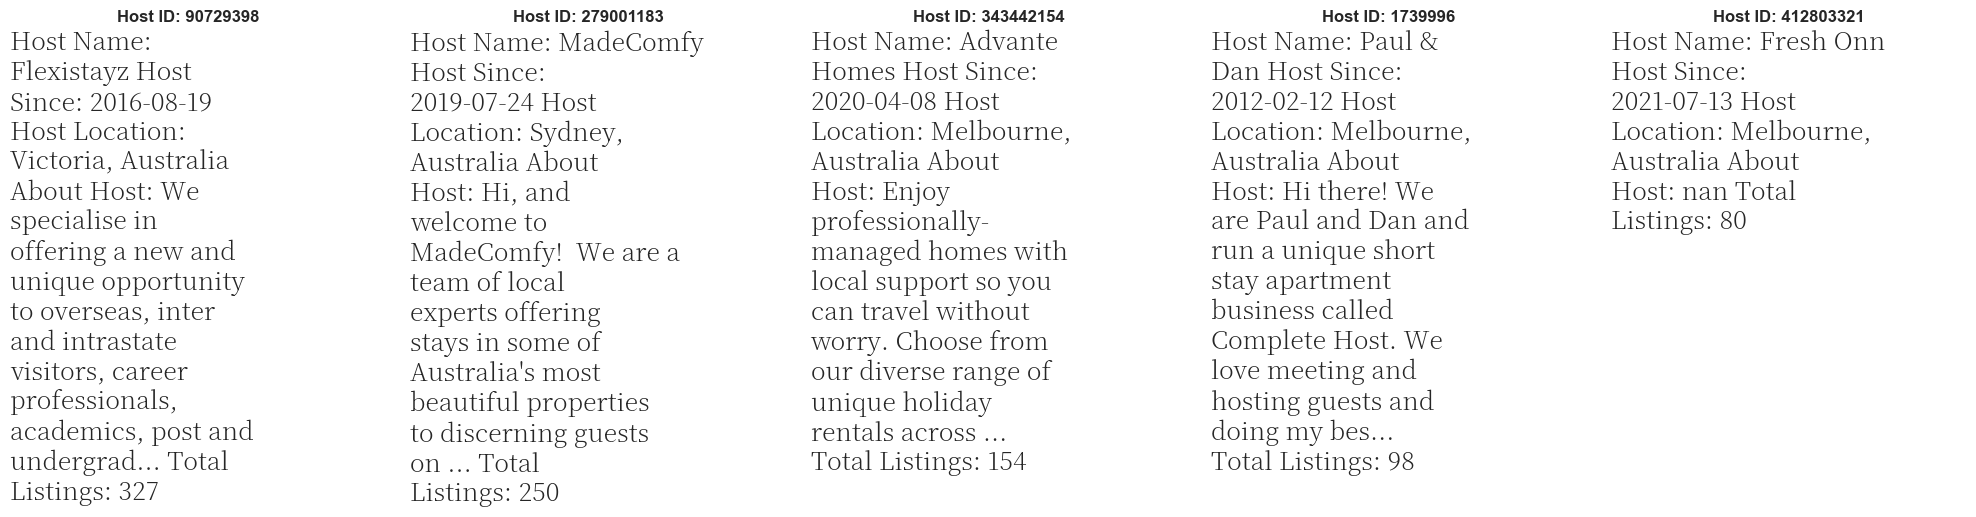

Top hosts in singapore:


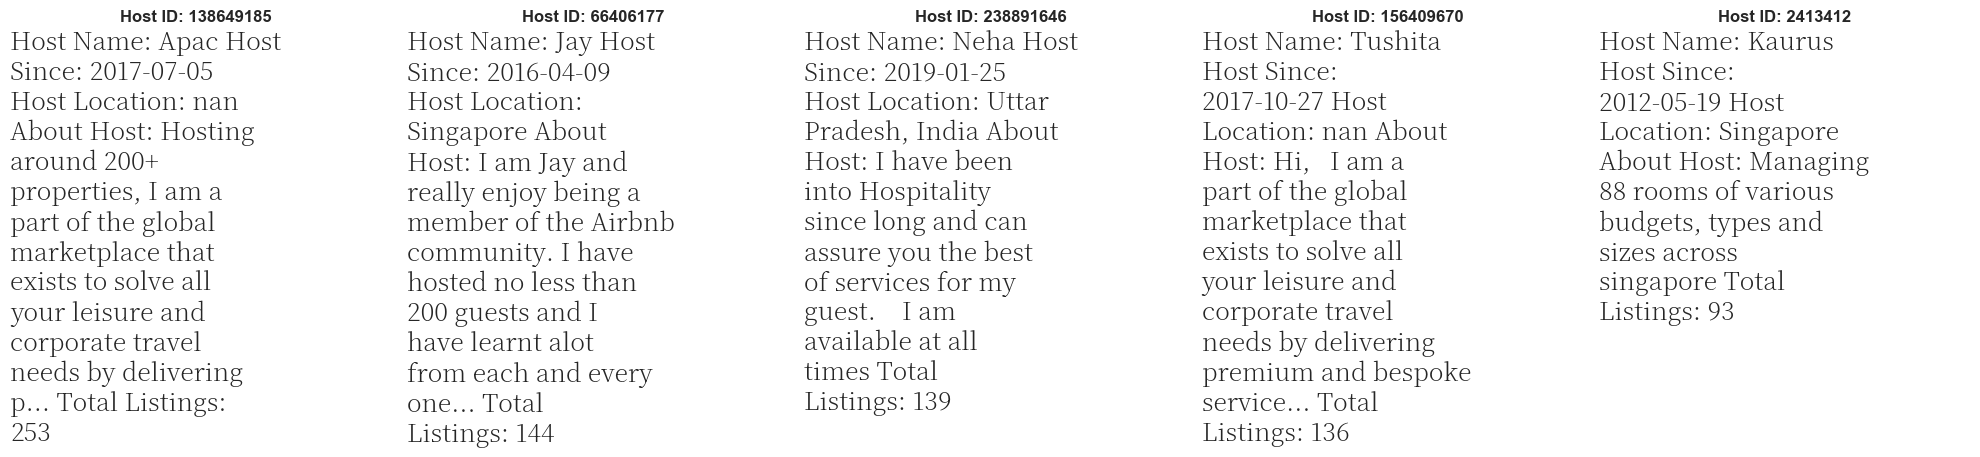

Top hosts in hongkong:


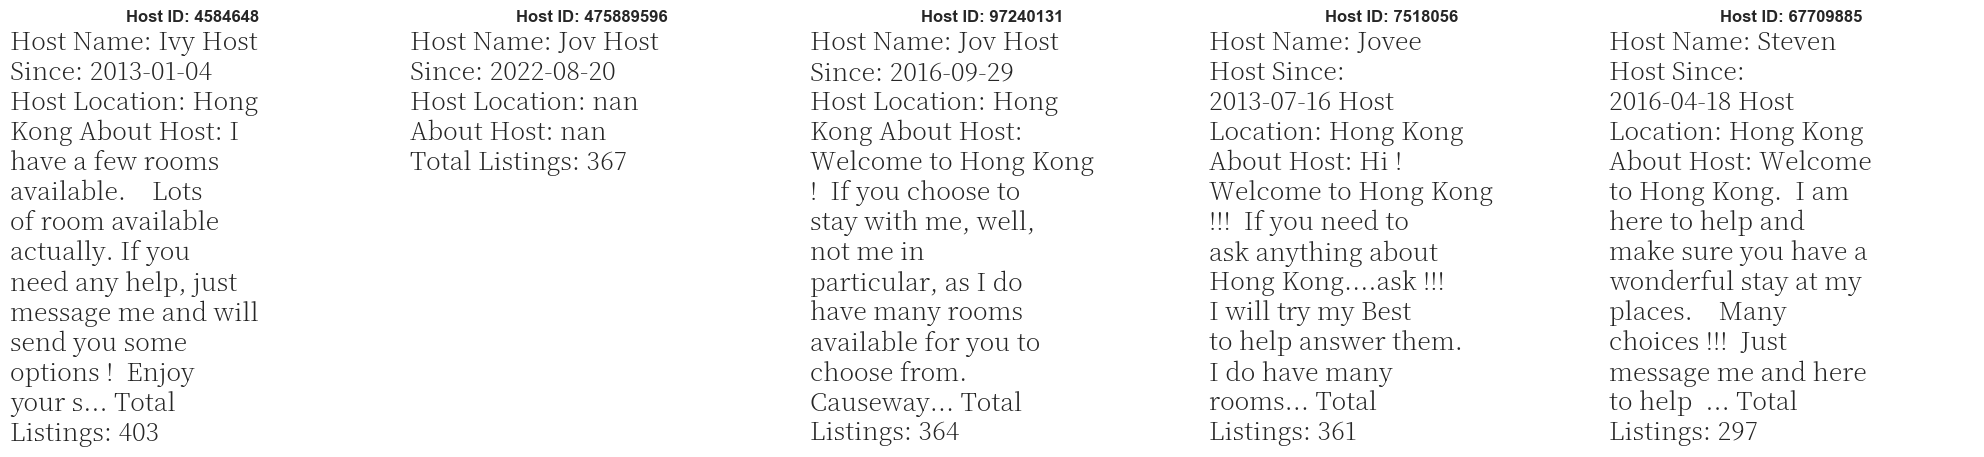

Top hosts in taipei:


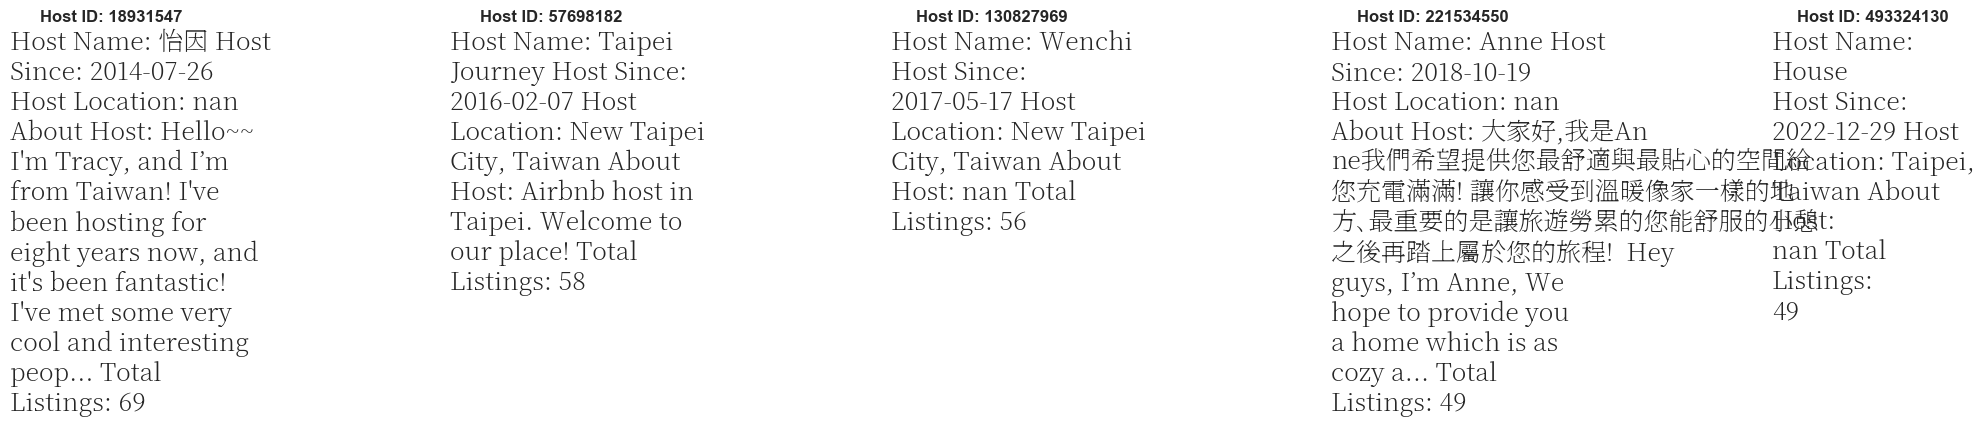

Top hosts in bangkok:


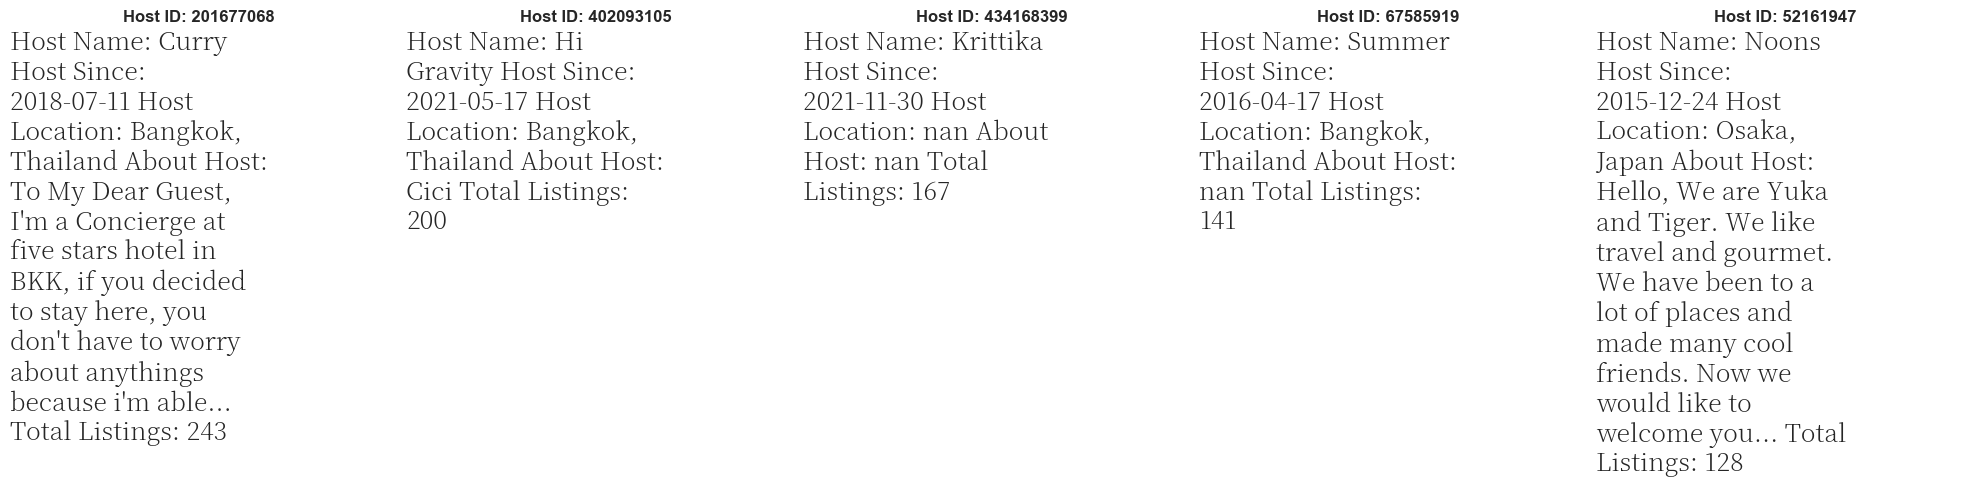

In [90]:
from matplotlib.font_manager import FontProperties
import textwrap
from matplotlib import font_manager
import matplotlib

fontprop = font_manager.FontProperties(fname='./font/NotoSerifCJK-VF.otf.ttc', size=18)


def display_host_profiles(cities_df):
    # Helper function to truncate long text
    def truncate_text(text, max_length=150):
        if len(str(text)) > max_length:
            truncated_text = text[:max_length] + "..."
        else:
            truncated_text = text
        return truncated_text

    # For each city, we will create a separate figure with profile cards
    for city, city_df in cities_df.items():
        print(f"Top hosts in {city}:")

        # Identify the top hosts
        host_listings_df = city_df.groupby('host_id').size().reset_index(name='num_listings')
        host_listings_df.sort_values(by='num_listings', ascending=False, inplace=True)
        top_hosts = host_listings_df.head(5)  # Top 5 hosts

        # Create a new figure with subplots for profile cards
        fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust as needed
        axs = axs.flatten()  # Flatten to easily iterate

        for i, (index, row) in enumerate(top_hosts.iterrows()):
            host_id = row['host_id']
            host_details = city_df[city_df['host_id'] == host_id].iloc[0]  # Get the host's details

            # Prepare text for the profile card, truncating long 'About' text
            about_host = truncate_text(host_details['host_about'])
            profile_text = (f"Host Name: {host_details['host_name']}\n"
                            f"Host Since: {host_details['host_since']}\n"
                            f"Host Location: {host_details['host_location']}\n"
                            f"About Host: {about_host}\n"
                            f"Total Listings: {row['num_listings']}")

            # Wrap text and align to the left
            wrapped_text = textwrap.fill(profile_text, width=20)  # Adjust width as needed

            # Add text to the subplot
            axs[i].text(0, 1, wrapped_text, ha='left', va='top', wrap=True, transform=axs[i].transAxes, font=fontprop)
            axs[i].set_title(f"Host ID: {host_id}", fontweight='bold')
            axs[i].axis('off')  # Hide axes

        # If there are fewer than 10 top hosts, we need to delete the remaining subplots
        for j in range(i+1, 10):
            fig.delaxes(axs[j])

        plt.tight_layout()
        plt.show()

# Call the function with your data
display_host_profiles(cities_df)


#### 1.4 Review scores in each city
All the cities have similar median review scores, which are around 4.7.

However, the distribution of review scores seem to be different among the cities.
Tokyo has concentrated review scores in every review category, while other cities have more spread-out review scores.

On the other hand, Tokyo seems to have lower review scores in the "location" category, which sounds contradictory to the fact that Tokyo has well-developed public transportation system.

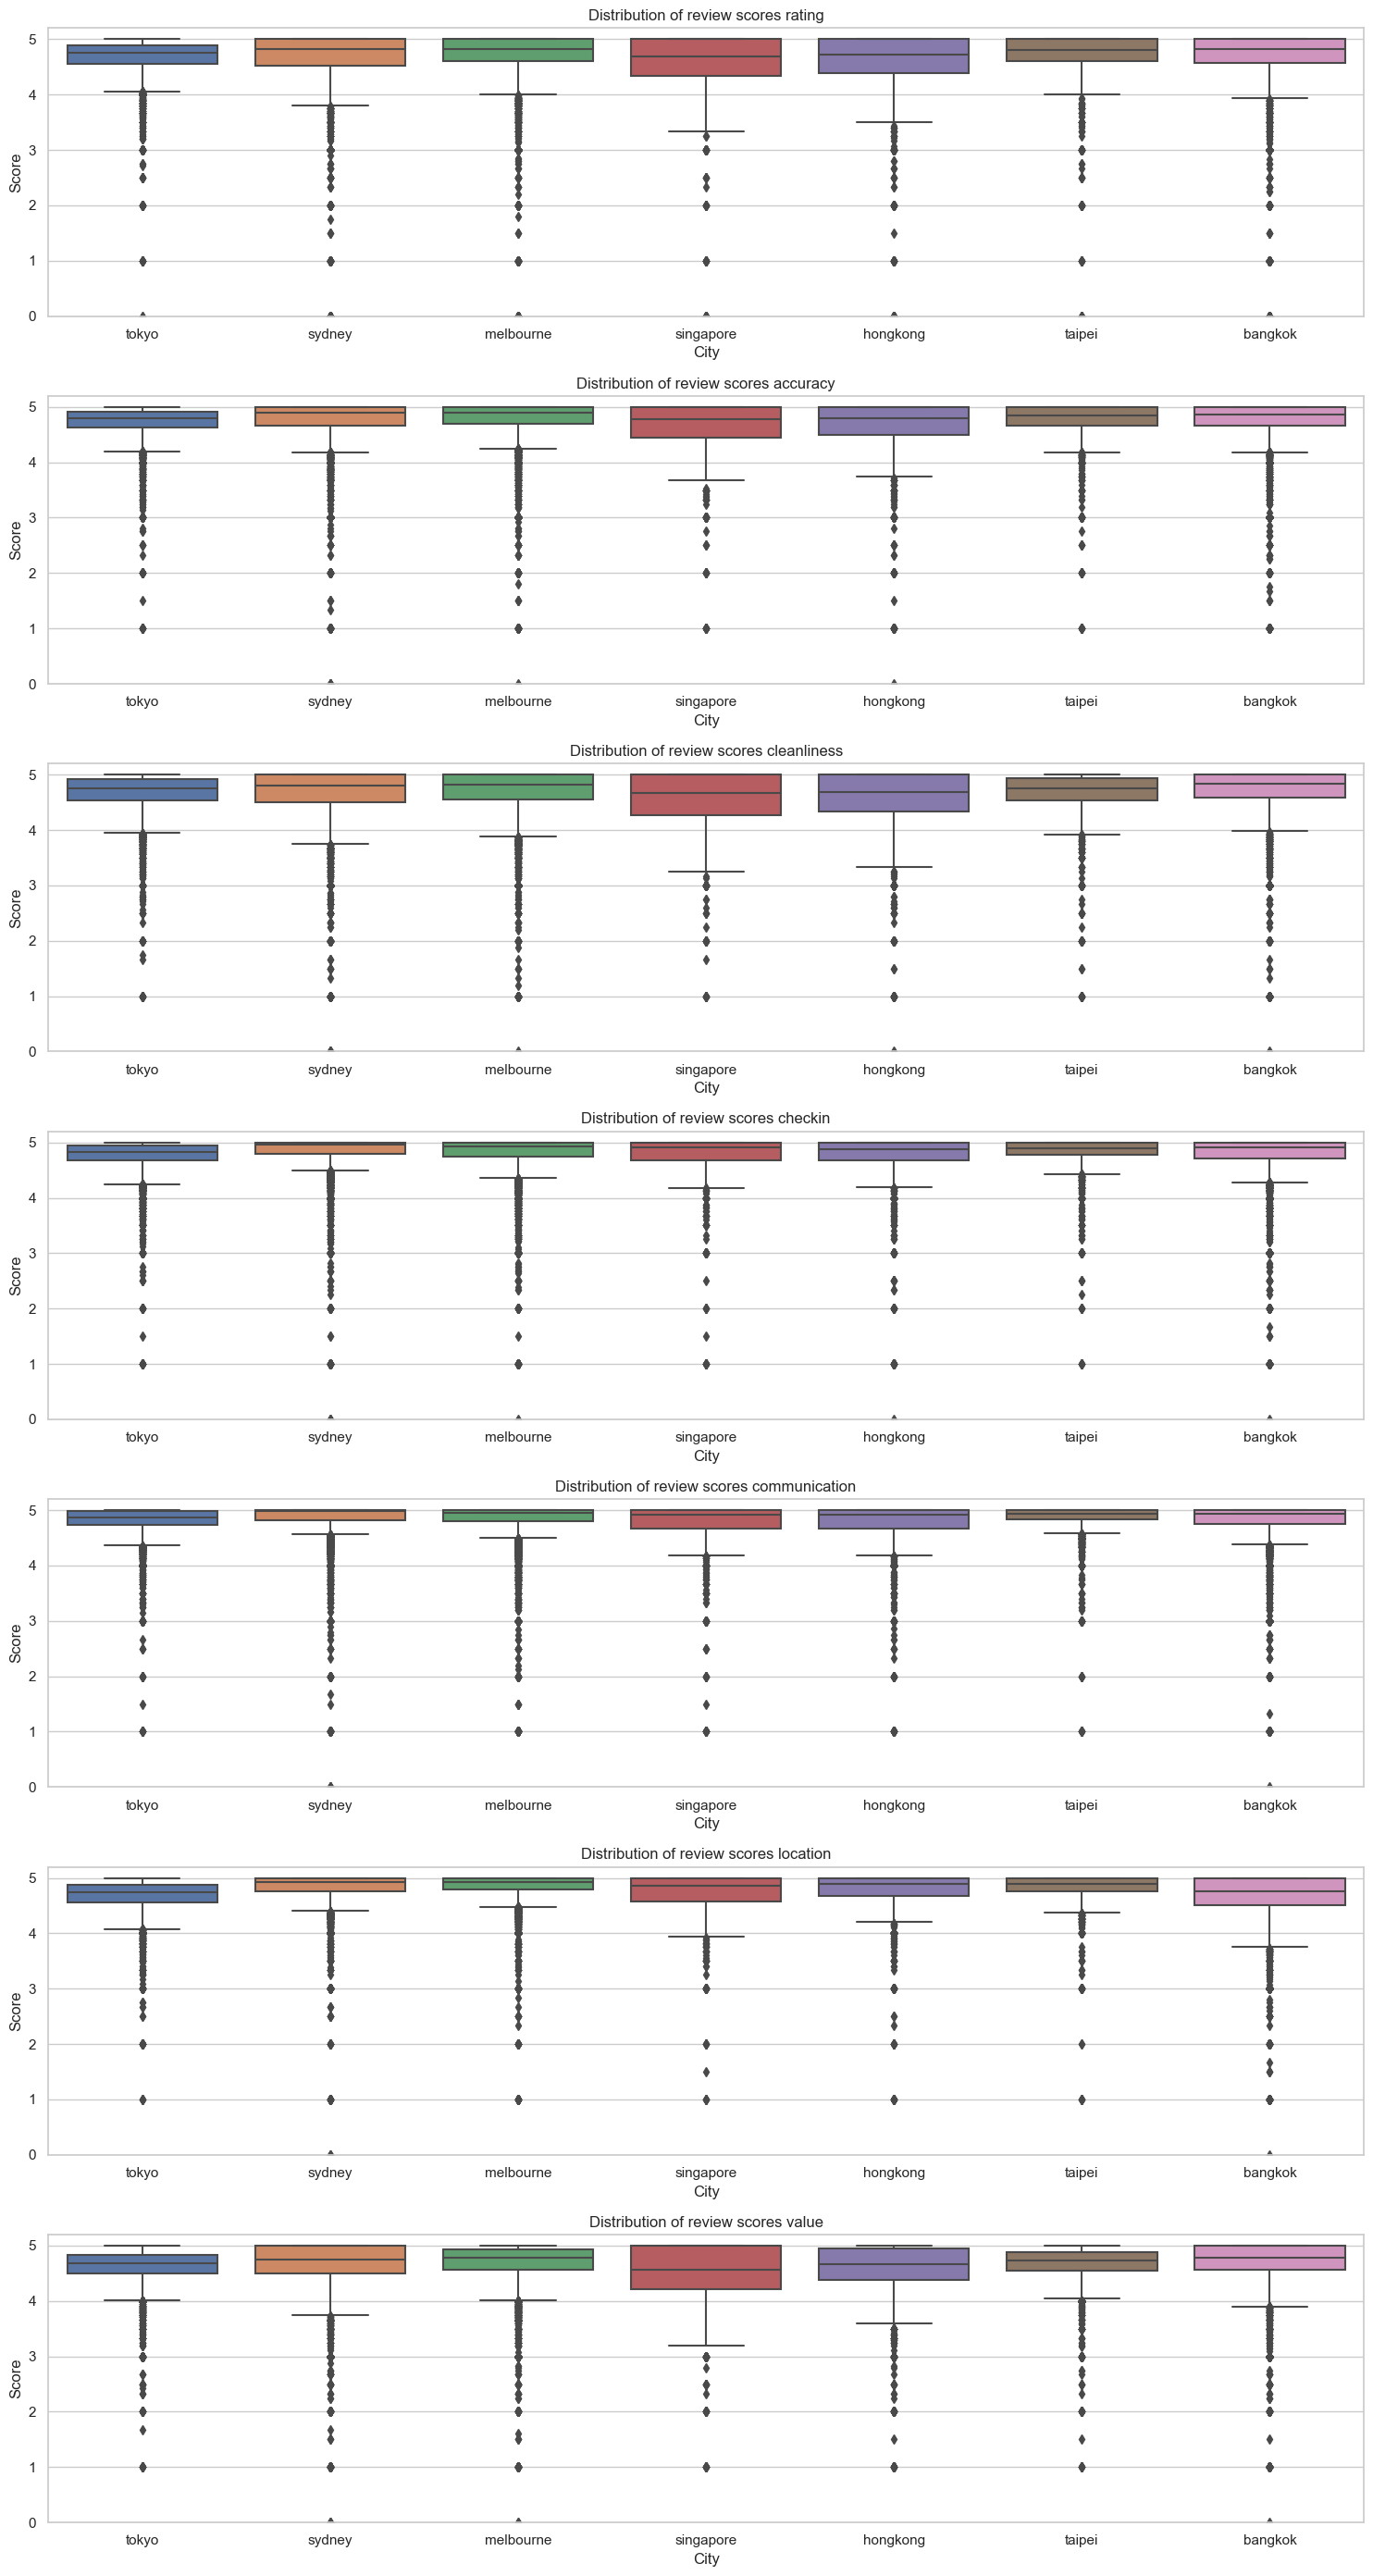

In [69]:
# Box-plot the distribution of review scores in each city
review_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

fig, axs = plt.subplots(len(review_columns), 1, figsize=(15, 4 * len(review_columns)))

for i, review_col in enumerate(review_columns):
    data_to_plot = []

    for city, city_df in cities_df.items():
        scores = city_df[review_col].dropna()

        for score in scores:
            data_to_plot.append({'city': city, 'score': score})

    plot_df = pd.DataFrame(data_to_plot)

    sns.boxplot(x='city', y='score', data=plot_df, ax=axs[i])

    axs[i].set_title(f'Distribution of {review_col.replace("_", " ")}')
    axs[i].set_xlabel('City')
    axs[i].set_ylabel('Score')

    axs[i].set_ylim(0, 5.2)  # Assuming the scores are on a scale of 5

plt.tight_layout()
plt.show()


The tables below show the quantiles and standard deviation of review scores in each city.
Those colored in blue are the lowest score in the category, and those colored in red are the highest.

/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_18471/1466752849.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(pd.Series(city_stats, name=city))
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_18471/1466752849.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(pd.Series(city_stats, name=city))
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_18471/1466752849.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(pd.Series(city_stats, name=city))
/var/folders/0g/nspdpmq17sjcnd9jnfmr40m80000gn/T/ipykernel_18471/1466752849.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pa

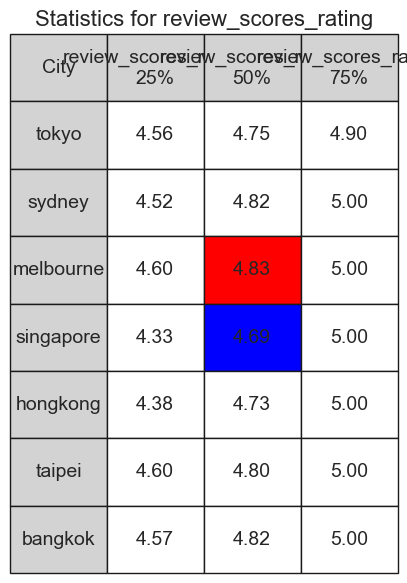

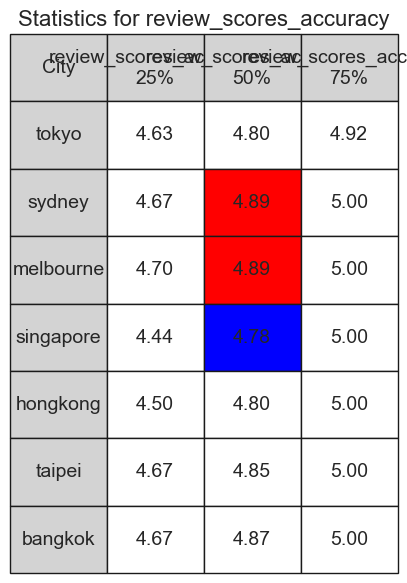

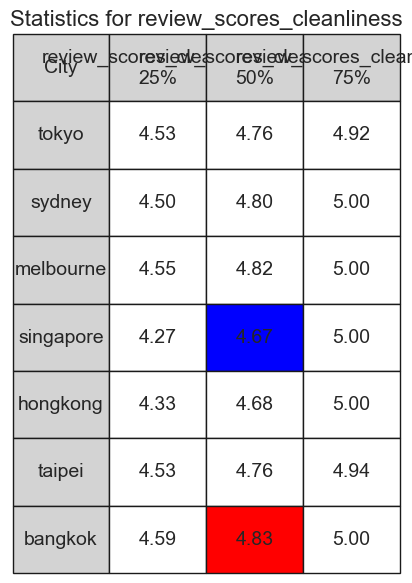

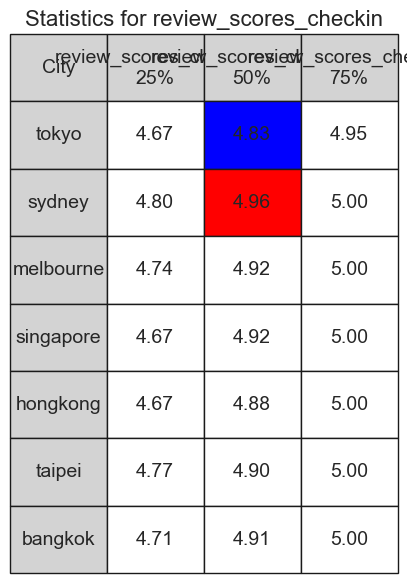

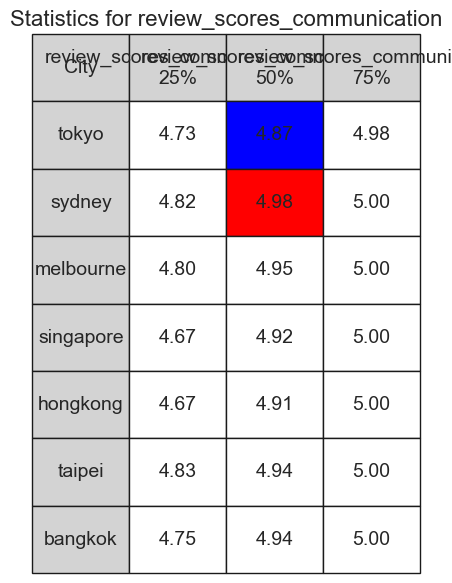

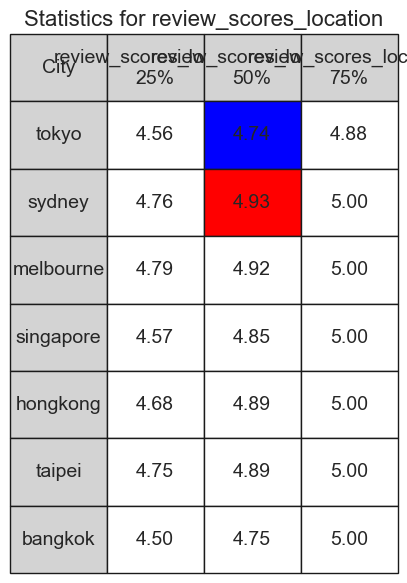

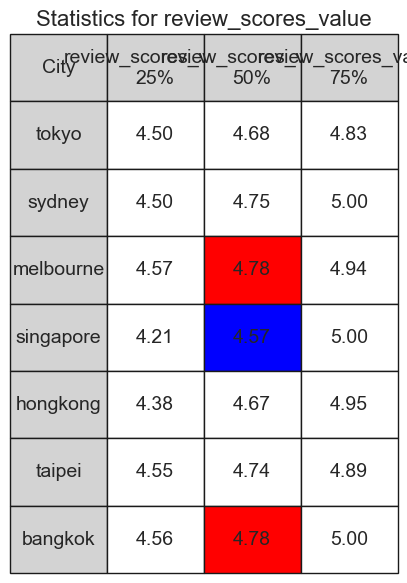

In [70]:
from matplotlib.table import Table
from matplotlib.font_manager import FontProperties

def determine_color(value, column):
    if value == column.min():
        return "blue"
    if value == column.max():
        return "red"
    return "white"

# List of review columns
review_columns = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

# Calculate statistics for each city and review column
stats_df = pd.DataFrame()

for city, city_df in cities_df.items():
    city_stats = {}
    for column in review_columns:
        city_stats[column] = {
            '25%': city_df[column].quantile(0.25),
            '50%': city_df[column].quantile(0.50),
            '75%': city_df[column].quantile(0.75),
        }
    stats_df = stats_df.append(pd.Series(city_stats, name=city))

# Create a separate table for each review column
for review_column in review_columns:
    fig, ax = plt.subplots(figsize=(5, len(cities_df)))
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False) # Don't delete this line, otherwise the table won't be visible
    table.set_fontsize(16)

    num_rows, num_cols = len(stats_df) + 1, 5  # 4 statistics + city names
    height, width = 1.0 / num_rows, 1.0 / num_cols

    fontsize = 14

    # Add header
    table.add_cell(0, 0, width, height, text="City", loc="center", facecolor="lightgray", fontproperties=FontProperties(size=fontsize))
    for i, stat in enumerate(['25%', '50%', '75%']):
        table.add_cell(0, i + 1, width, height, text=f"{review_column}\n{stat}", loc="center", facecolor="lightgray", fontproperties=FontProperties(size=fontsize))

    # Add rows
    for i, (city, city_stats) in enumerate(stats_df.iterrows(), 1):
        table.add_cell(i, 0, width, height, text=city, loc="center", facecolor="lightgray", fontproperties=FontProperties(size=fontsize))

        review_stats = city_stats[review_column]
        for j, (stat, value) in enumerate(review_stats.items()):
            color = "white"
            if stat == '50%':
                color = determine_color(value, stats_df[review_column].apply(lambda x: x[stat]))

            table.add_cell(i, j + 1, width, height, text=f"{value:.2f}", loc="center", facecolor=color, fontproperties=FontProperties(size=fontsize))

    ax.add_table(table)
    plt.title(f"Statistics for {review_column}", fontsize=16)
    plt.show()


The graph below shows the standard deviation of review scores in each city.
Tokyo has the lowest standard deviation in most of the review categories, which means that the review scores in Tokyo are more concentrated than other cities.

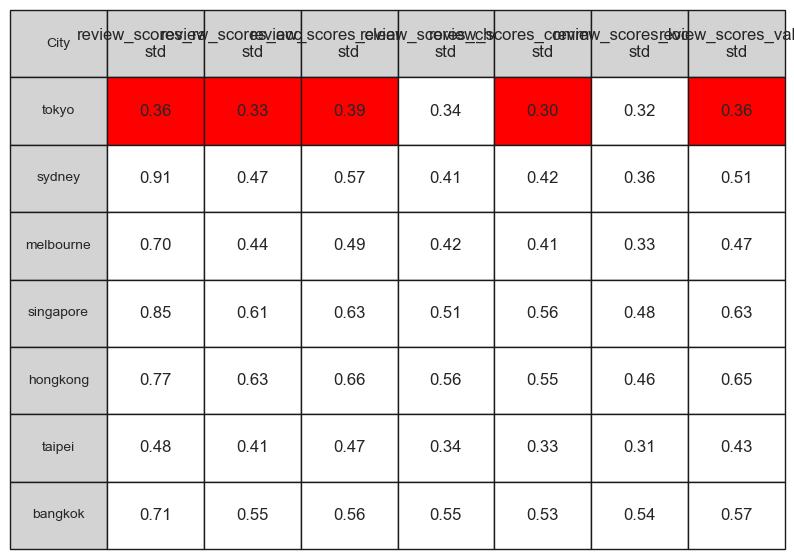

In [71]:
# Calculate statistics for each city
stats = {}
for city, df in cities_df.items():
    city_stats = {}
    for col in review_columns:
        city_stats[col] = {
            'std': df[col].std()
        }
    stats[city] = city_stats

stats_df = pd.DataFrame(stats).T  # Transpose to have cities as rows

def should_highlight(cell, column):
    return cell == column.max() or cell == column.min()

fig, ax = plt.subplots(figsize=(10, len(cities_df)))
ax.axis('off')

table = Table(ax, bbox=[0, 0, 1, 1])

num_rows, num_cols = 1, len(review_columns) * 4 + 1  # 1 statistics per review column + city names
height, width = 1.0 / num_rows, 1.0 / num_cols

table.auto_set_font_size(False) # Don't delete this line, otherwise the table won't be visible
table.set_fontsize(16)
# Add header
table.add_cell(0, 0, width, height, text="City", loc="center", facecolor="lightgray", fontproperties=FontProperties(size=10))
for i, column in enumerate(review_columns, 1):
    for j, stat in enumerate(['std']):
        table.add_cell(0, (i - 1) * 4 + j + 1, width, height, text=f"{column}\n{stat}", loc="center", facecolor="lightgray")

# Add rows
for i, (city, city_stats) in enumerate(stats_df.iterrows(), 1):
    table.add_cell(i, 0, width, height, text=city, loc="center", facecolor="lightgray", fontproperties=FontProperties(size=10))

    for j, (review, review_stats) in enumerate(city_stats.items()):
        for k, (stat, value) in enumerate(review_stats.items()):
            # Check if we should highlight this cell
            highlight = should_highlight(value, stats_df[review].apply(lambda x: x[stat]))
            color = "red" if highlight and city == "tokyo" else "white"

            table.add_cell(i, j * 4 + k + 1, width, height, text=f"{value:.2f}", loc="center", facecolor=color)



ax.add_table(table)
plt.show()


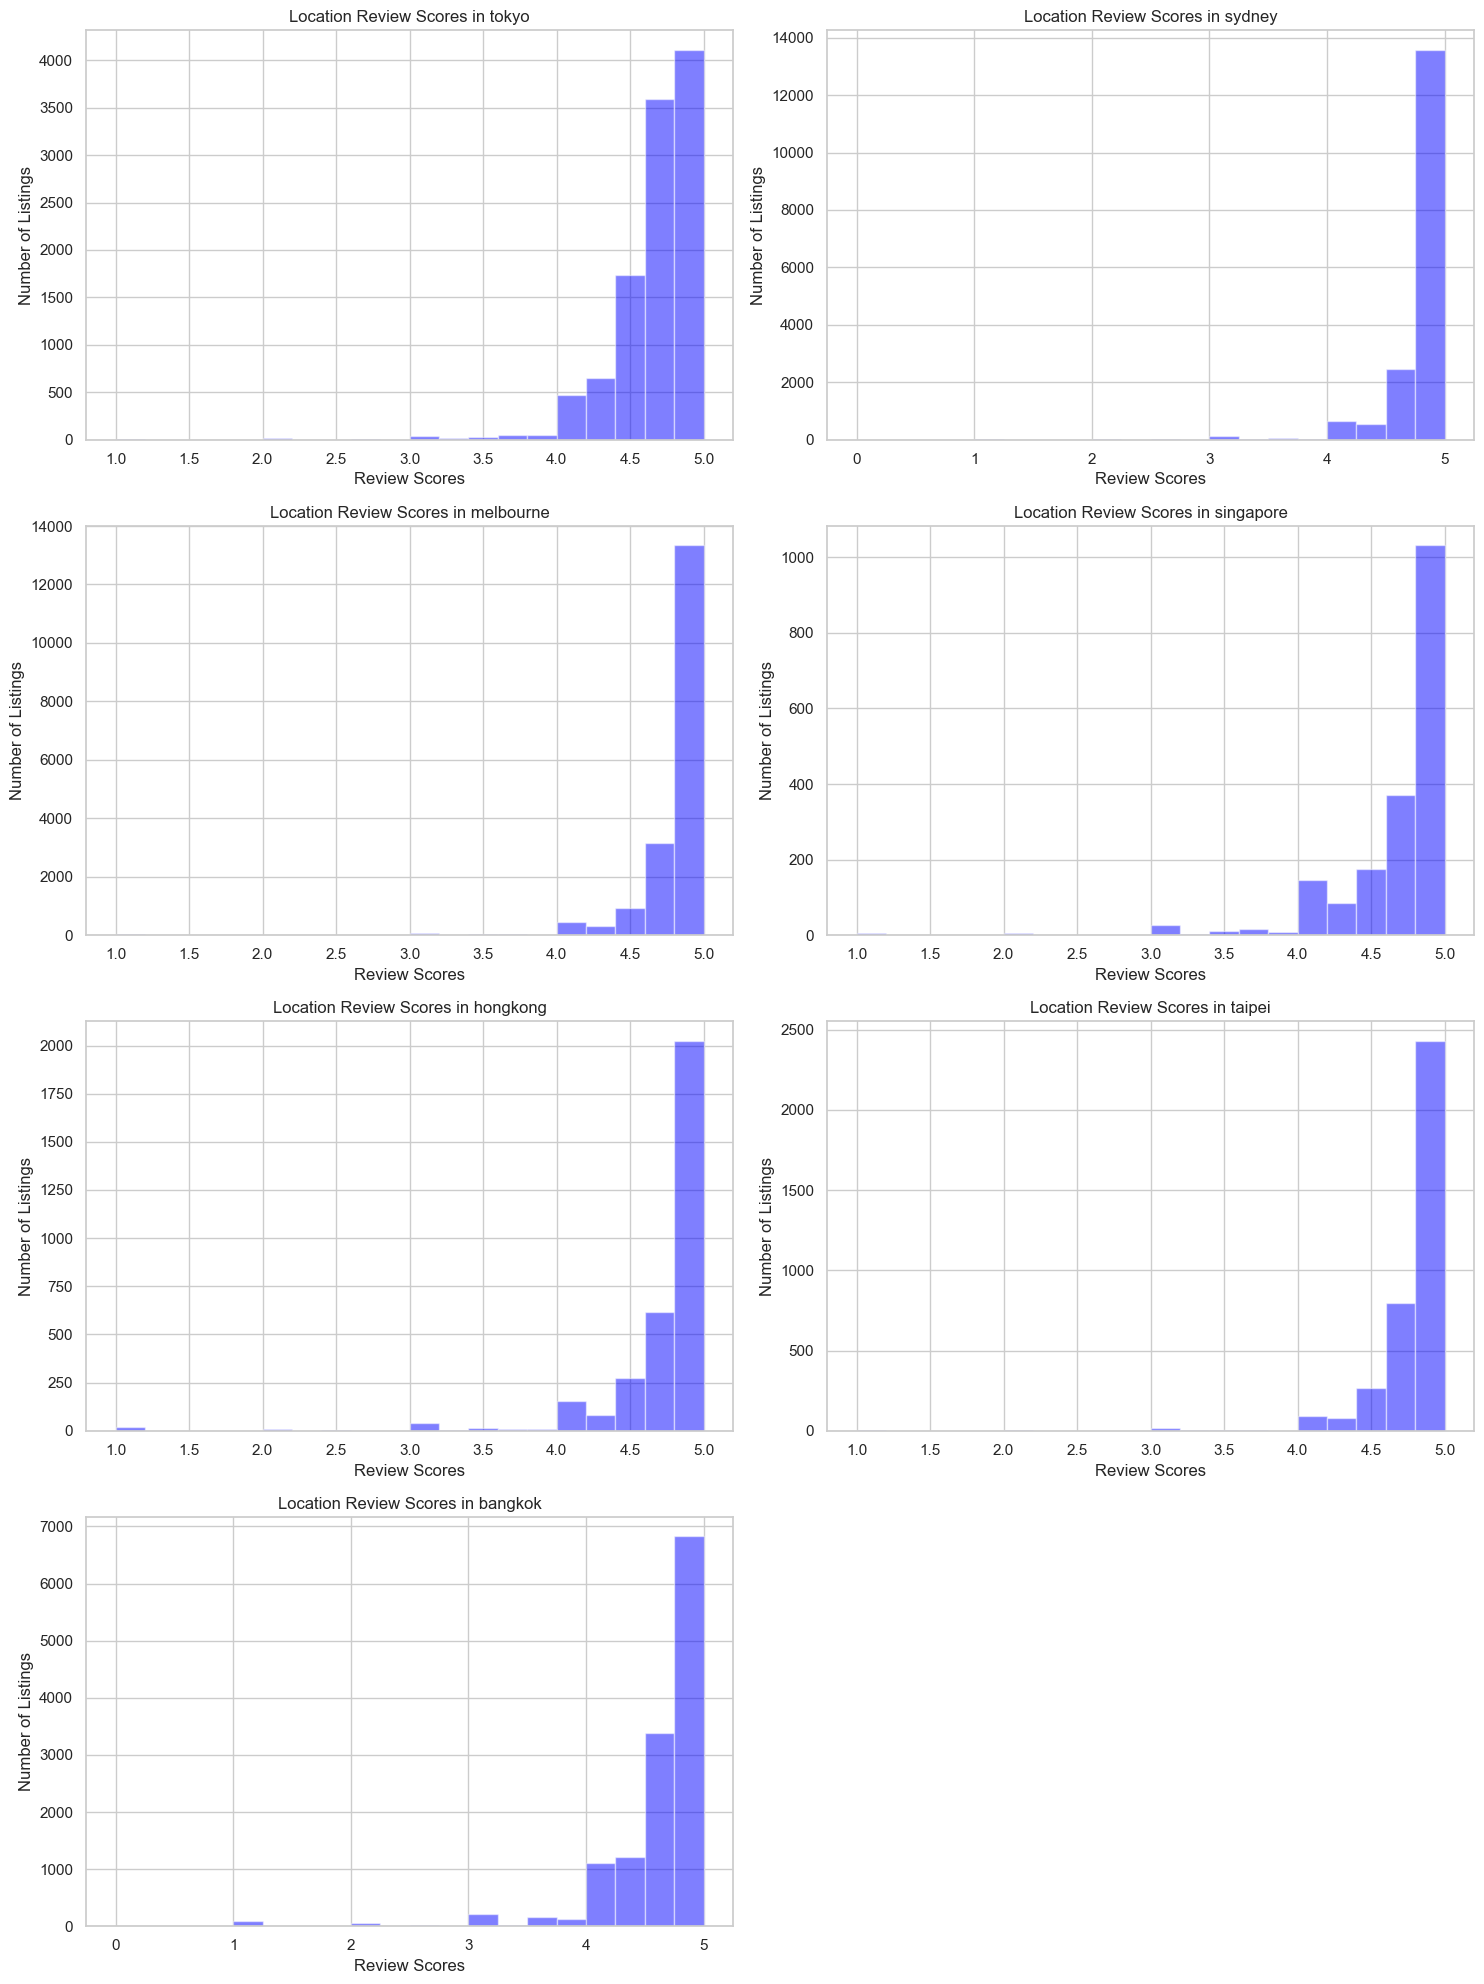

In [72]:
# Plot the histogram of location review scores in each city
import matplotlib.pyplot as plt


num_cities = len(cities_df)
cols = 2
rows = num_cities // cols + num_cities % cols

plt.figure(figsize=(15, 5 * rows))

# Create a histogram for each city
for i, (city, city_df) in enumerate(cities_df.items()):
    plt.subplot(rows, cols, i + 1)  # Define the subplot
    plt.hist(city_df['review_scores_location'].dropna(), bins=20, alpha=0.5, color='blue')  # Adjust number of bins as needed
    plt.title(f'Location Review Scores in {city}')
    plt.xlabel('Review Scores')
    plt.ylabel('Number of Listings')
    plt.tight_layout()  # To avoid overlap

# Show the plot
plt.show()



I conducted Mann-Whitney U test to determine if there's a significant difference in location review scores between Tokyo and other cities.

The Mann-Whitney U test is a nonparametric test used to compare two independent samples. It tests the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X. In this case, the null hypothesis states that there's no difference in the distribution of location review scores between Tokyo and the other cities.

The reason why I chose Mann-Whitney U over t-test is that the distribution of location review scores in each city is not normal as shown in the previous histograms. Also, it is impossible to normalize the data sets since most of the data is located at very right.

The extremely low p-values suggest that the differences in location scores between Tokyo and the other cities are not due to random chance.

In [83]:
results = {}

tokyo_reviews = cities_df['tokyo']['review_scores_location'].dropna()

for city, city_df in cities_df.items():
    if city == 'tokyo':
        continue
    current_city_reviews = city_df['review_scores_location'].dropna()

    # Perform Mann-Whitney U test
    stat, p = mannwhitneyu(tokyo_reviews, current_city_reviews, alternative='two-sided')

    results[city] = {'statistic': stat, 'p-value': p}

for city, result in results.items():
    if city == 'tokyo':
        continue
    print(f"Comparison with {city.capitalize()}: U-statistic = {result['statistic']: .10f}, p-value = {result['p-value']: .10f}")


Comparison with Sydney: U-statistic =  56948450.0000000000, p-value =  0.0000000000
Comparison with Melbourne: U-statistic =  58228841.0000000000, p-value =  0.0000000000
Comparison with Singapore: U-statistic =  8214174.0000000000, p-value =  0.0000000000
Comparison with Hongkong: U-statistic =  12438562.5000000000, p-value =  0.0000000000
Comparison with Taipei: U-statistic =  13108900.5000000000, p-value =  0.0000000000
Comparison with Bangkok: U-statistic =  68747312.0000000000, p-value =  0.0000011545


## 2. Why does Tokyo have low review scores in the "location" category?

In [ ]:
reviews_df = dict()
for city in city_names:
    reviews_df[city] = pd.read_csv("./data/reviews_{c}.csv".format(c=city))

In [ ]:
df_full_tokyo = pd.merge(cities_df["tokyo"], reviews_df["tokyo"], left_on='id', right_on='listing_id')

df_full_tokyo['all_reviews'] = df_full_tokyo.apply(lambda row: f"Score: {row['review_scores_location']}<br>Review: {row['comments']}", axis=1)

# This step concatenates all reviews and scores for each listing into a single string.
df_full_tokyo['all_reviews'] = df_full_tokyo.groupby('listing_id')['all_reviews'].transform(lambda x: '<br><br>'.join(x))

# Drop duplicate listings, keeping only the first entry (which now contains all reviews and scores)
df_full = df_full_tokyo.drop_duplicates(subset='listing_id')


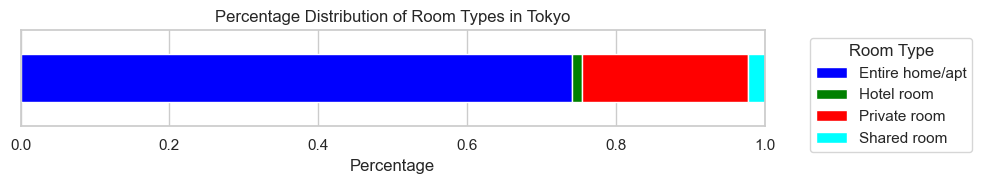

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_tokyo is the DataFrame for Tokyo listings
df_tokyo = cities_df['tokyo']

# Calculate the percentage of each room type
room_type_percent = df_tokyo['room_type'].value_counts(normalize=True).sort_index()

# Create a DataFrame for plotting
df_plot = pd.DataFrame([room_type_percent])

# Plot
fig, ax = plt.subplots(figsize=(10, 2))
df_plot.plot(kind='barh', stacked=True, ax=ax, color=['blue', 'green', 'red', 'cyan'], width=0.5)
ax.set_xlim(0, 1)  # Set x-axis limits to 0-1 for percentage
ax.set_xlabel('Percentage')
ax.set_title('Percentage Distribution of Room Types in Tokyo')
ax.get_yaxis().set_visible(False)  # Hide y-axis
ax.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


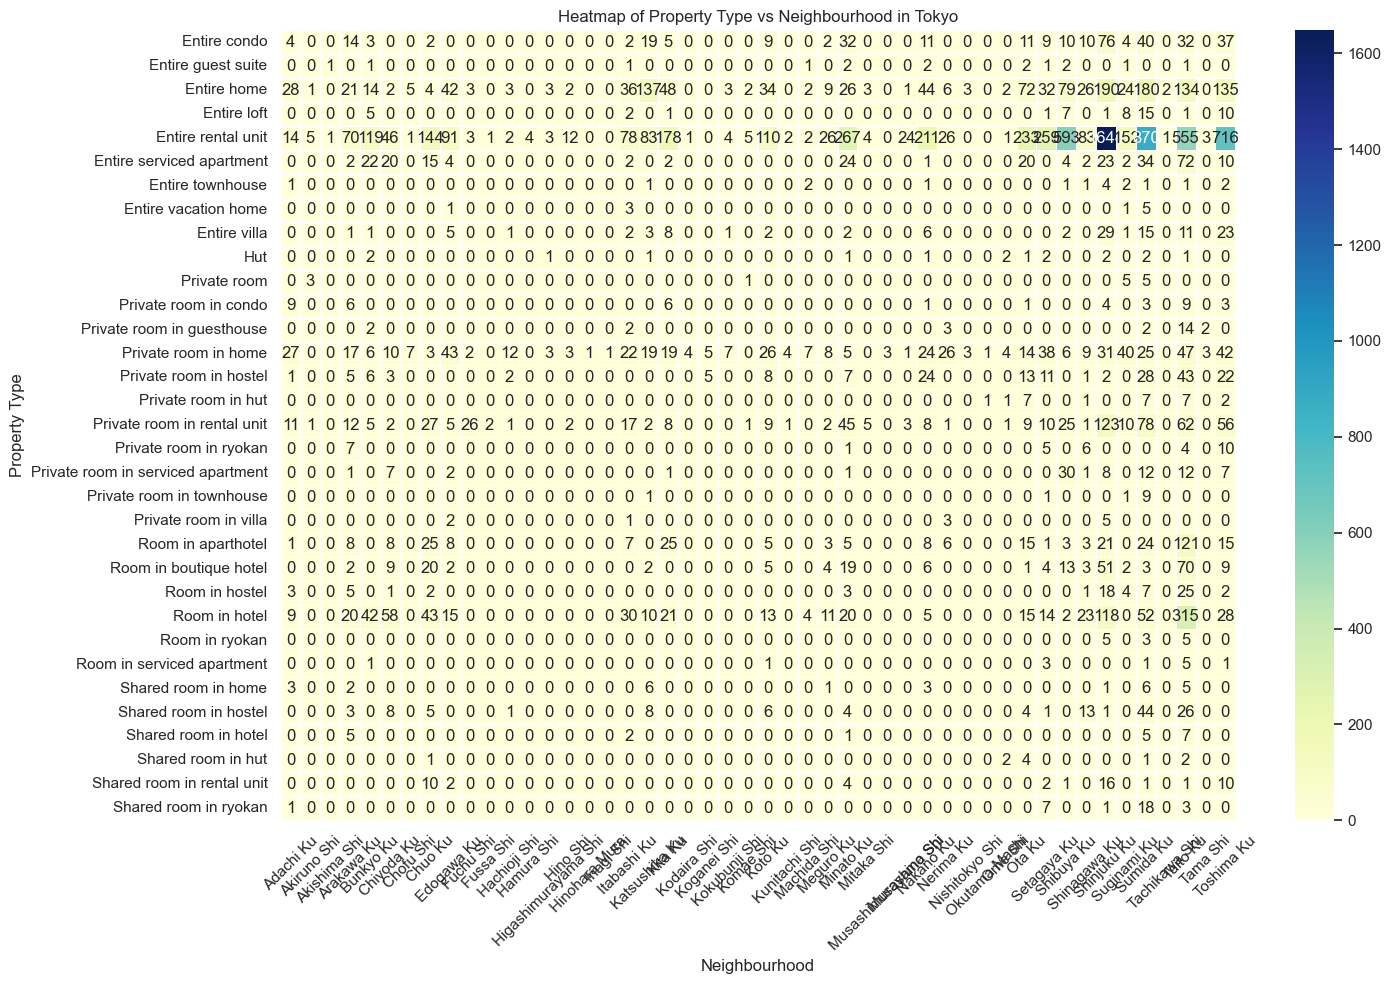

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_tokyo is the DataFrame for Tokyo listings
df_tokyo = cities_df['tokyo']

# Filter out property types with fewer than 10 listings
property_counts = df_tokyo['property_type'].value_counts()
property_to_keep = property_counts[property_counts >= 10].index
filtered_df = df_tokyo[df_tokyo['property_type'].isin(property_to_keep)]

# Create a pivot table with counts of each combination of property_type and neighbourhood_cleansed
pivot_table = filtered_df.pivot_table(index='property_type', columns='neighbourhood_cleansed', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)
plt.title('Heatmap of Property Type vs Neighbourhood in Tokyo')
plt.ylabel('Property Type')
plt.xlabel('Neighbourhood')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(filtered_df['property_type'], filtered_df['neighbourhood_cleansed'])

# Conduct the Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

# Interpret the result
alpha = 0.05
if p < alpha:
    print("There is a significant relationship between property type and neighbourhood.")
else:
    print("There is no significant relationship between property type and neighbourhood.")


In [ ]:
neighbourhood_scores = df_full_tokyo.groupby('neighbourhood_cleansed')['review_scores_location'].mean()

neighbourhood_scores_sorted = neighbourhood_scores.reset_index().sort_values('review_scores_location', ascending=False)
neighbourhood_scores_sorted.reset_index(drop=True, inplace=True)
print(neighbourhood_scores_sorted.head(10))


To find relation between location review scores and neighbourhoods, I conducted Kruskal-Wallis test for each neighbourhood and property type.
The null hypothesis is that there is no difference in location review scores between neighbourhoods/property type.

The extremely low p-values in both suggest that the differences in location scores between neighbourhoods are not due to random chance.

In [ ]:
from scipy import stats

neighbourhood_scores = df_full_tokyo.groupby('neighbourhood_cleansed')['review_scores_location'].mean()

neighbourhood_scores_sorted = neighbourhood_scores.reset_index().sort_values('review_scores_location', ascending=False)
neighbourhood_scores_sorted.reset_index(drop=True, inplace=True)
print("Top 10 neighbourhoods with highest location review scores")
print(neighbourhood_scores_sorted.head(10))

groups = [df_full_tokyo['review_scores_location'][df_full_tokyo['neighbourhood_cleansed'] == name] for name in df_full_tokyo['neighbourhood_cleansed'].unique()]

H, pval = stats.kruskal(*groups)

print()
print('Kruskal-Wallis H-test for neighbourhoods')
print('H-statistic:', H)
print(f'P-Value: {pval:.10f}')


In [ ]:
from scipy import stats

neighbourhood_scores = df_full_tokyo.groupby('property_type')['review_scores_location'].mean()

neighbourhood_scores_sorted = neighbourhood_scores.reset_index().sort_values('review_scores_location', ascending=False)
neighbourhood_scores_sorted.reset_index(drop=True, inplace=True)
print("Top 10 property_type with highest location review scores")
print(neighbourhood_scores_sorted.head(10))

groups = [df_full_tokyo['review_scores_location'][df_full_tokyo['property_type'] == name] for name in df_full_tokyo['property_type'].unique()]

H, pval = stats.kruskal(*groups)

print()
print('Kruskal-Wallis H-test for property types')
print('H-statistic:', H)
print(f'P-Value: {pval:.10f}')

In [ ]:
import geopandas as gpd

gdf = gpd.read_file('data/N02-20_Station.geojson')

In [ ]:
def extract_coords(geom):
    if geom.geom_type == 'MultiLineString':
        return geom.geoms[0].coords[0]  # Get the first line segment's first coordinate
    else:
        return geom.coords[0]  # For simple LineString geometries

# Convert GeoJSON to DataFrame
stations_df = pd.DataFrame({
    'station_name': gdf['N02_005'],
    'longitude': gdf['geometry'].apply(lambda geom: extract_coords(geom)[0]),
    'latitude': gdf['geometry'].apply(lambda geom: extract_coords(geom)[1]),
    'train_line': gdf['N02_004']
})

# Haversine formula to calculate distance
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

# Find nearest station for each listing
nearest_stations = []
distances = []
train_lines = []

for idx, row in df_full.iterrows():
    distances_to_stations = stations_df.apply(lambda station: haversine(row['longitude'], row['latitude'], station['longitude'], station['latitude']), axis=1)
    min_distance_idx = distances_to_stations.idxmin()
    nearest_stations.append(stations_df.iloc[min_distance_idx]['station_name'])
    distances.append(distances_to_stations[min_distance_idx])
    train_lines.append(stations_df.iloc[min_distance_idx]['train_line'])

# Update DataFrame
df_full['nearest_station'] = nearest_stations
df_full['distance_to_station'] = distances
df_full['train_line'] = train_lines

# Save to CSV
df_full.to_csv('listings_tokyo_merged.csv', index=False)

In [ ]:
correlation = df_full['distance_to_station'].corr(df_full['review_scores_location'])
print(f"Correlation between distance to nearest station and location review scores: {correlation:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_full['distance_to_station'], df_full['review_scores_location'], alpha=0.5)
plt.title('Relationship between Distance to Nearest Station and Location Review Scores')
plt.xlabel('Distance to Nearest Station (km)')
plt.ylabel('Location Review Scores')
plt.grid(True)
plt.show()


In [ ]:
def get_confidence_interval(df):
    r = -0.25
    n = len(df)

    # Fisher's Z Transformation
    z = 0.5 * np.log((1 + r) / (1 - r))

    # Standard error of z
    SE_z = 1/np.sqrt(n-3)

    # 95% CI for z
    z_alpha_2 = 1.96  # for 95% CI
    z_lower = z - z_alpha_2 * SE_z
    z_upper = z + z_alpha_2 * SE_z

    # Transform z CI back to r
    r_lower = (np.exp(2*z_lower) - 1) / (np.exp(2*z_lower) + 1)
    r_upper = (np.exp(2*z_upper) - 1) / (np.exp(2*z_upper) + 1)

    print(f"95% Confidence Interval for the correlation coefficient: ({r_lower:.3f}, {r_upper:.3f})")

get_confidence_interval(df_full)

In [ ]:
import scipy.stats as stats
import japanize_matplotlib

medians = df_full.groupby('train_line')['review_scores_location'].median().sort_values(ascending=False)

groups = [df_full['review_scores_location'][df_full['train_line'] == train_line] for train_line in df_full['train_line'].unique()]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.boxplot(x='train_line', y='review_scores_location', data=df_full, order=medians.index)
plt.xticks(rotation=45)
plt.title('Boxplot of Location Review Scores by Train Line')
plt.show()


In [ ]:
from scipy import stats

neighbourhood_scores = df_full_tokyo.groupby('room_type')['review_scores_location'].mean()

neighbourhood_scores_sorted = neighbourhood_scores.reset_index().sort_values('review_scores_location', ascending=False)
neighbourhood_scores_sorted.reset_index(drop=True, inplace=True)
print("Top 10 room_type with highest location review scores")
print(neighbourhood_scores_sorted.head(10))

groups = [df_full_tokyo['review_scores_location'][df_full_tokyo['room_type'] == name] for name in df_full_tokyo['room_type'].unique()]

H, pval = stats.kruskal(*groups)

print()
print('Kruskal-Wallis H-test')
print('H-statistic:', H)
print(f'P-Value: {pval:.10f}')

In [ ]:
import MeCab
import collections

def get_words(text_list):
    t = MeCab.Tagger()

    words = []

    for word in text_list:
        node = t.parseToNode(word)
        while node:
            if node.surface != "":  # ヘッダとフッタを除外
                word_type = node.feature.split(",")[0]
                # 名詞だけをリストに追加する
                if word_type in ["名詞"]:
                    words.append(node.surface)
                # # 動詞（の原型），形容詞，副詞もリストに加えたい場合は次の２行を有効にする
                # if word_type in [ "動詞", "形容詞", "副詞"]:
                #     words.append(node.feature.split(",")[6])
            node = node.next
            if node is None:
                break
    return words


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from langdetect import detect
from collections import defaultdict

df = df_full_tokyo.copy()

low_score_quantile = df['review_scores_location'].quantile(0.25)
low_score_reviews = df[df['review_scores_location'] < low_score_quantile]['comments']

font_path = '/Users/mkurumi/DataspellProjects/pythonProject/airbnb/NotoSerifCJK-VF.otf.ttc'

reviews_by_language = defaultdict(list)
for review in low_score_reviews:
    try:
        language = detect(review)
        reviews_by_language[language].append(review)
    except Exception:
        pass

# Remove languages with less than 10 reviews
reviews_by_language = {language: reviews for language, reviews in reviews_by_language.items() if len(reviews) >= 100}

for language, reviews in reviews_by_language.items():
    text = ""

    if language == 'ja':
        text = " ".join(get_words(reviews))
    else:
        continue
    # elif language == 'en': # TODO: Improve how to handle different languages' reviews
    #     text = " ".join(str(reviews))
    # elif language == 'zh-tw':
    #     text = " ".join(str(reviews))
    # elif language == 'zh-cn':
    #     text = " ".join(str(reviews))
    # elif language == 'ko':
    #     text = " ".join(str(reviews))
    # else:
    #     text = " ".join(str(reviews))

    wordcloud = WordCloud(width=500, height=300, background_color='white', font_path=font_path).generate(text)

    # Display the generated image with matplotlib.
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Language: {language}')
    plt.axis('off')
    plt.show()


In [ ]:
fig, axs = plt.subplots(1, len(city_names), figsize=(20, 6))

for i, city in enumerate(city_names):
    city_df = cities_df[city]

    room_counts = city_df['room_type'].value_counts()

    sns.barplot(x=room_counts.index, y=room_counts.values, ax=axs[i])

    axs[i].set_title(f'Room types in {city}')
    axs[i].set_xlabel('Room Type')
    axs[i].set_ylabel('Number of listings')

    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

num_cities = len(cities_df)

cols = (num_cities + 2) // 3
fig, axs = plt.subplots(3, cols, figsize=(cols * 6, 18))

axs = axs.flatten()

for i, (city, city_df) in enumerate(cities_df.items()):
    numeric_columns = city_df.select_dtypes(include=[pd.np.number])

    to_remove = ['id', 'host_id', 'latitude', 'longitude', 'scrape_id']
    numeric_columns = numeric_columns.drop(to_remove, axis=1)
    for c in numeric_columns:
        if c.startswith('calculated'):
            numeric_columns.pop(c)

    # Compute the correlation matrix
    corr_matrix = numeric_columns.corr()

    # Create a heatmap for the current city's data in the subplot
    sns.heatmap(corr_matrix, ax=axs[i], cbar=True, cmap='coolwarm', square=True, cbar_kws={'shrink': 0.75})

    # Set the title for the current subplot
    axs[i].set_title(f'{city.capitalize()} Listings')

# If there are any remaining subplots (in case of non-multiple of 3), we remove them
for j in range(i+1, 3*cols):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
